# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 6.98KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

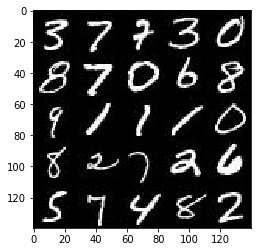

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

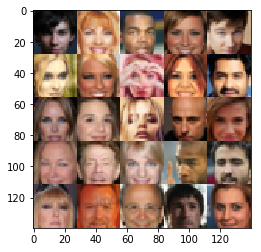

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inp = tf.placeholder(tf.float32,[None, image_width, image_height, image_channels], "real_input")
    z_inp = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    
    return real_inp, z_inp, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        
        hidden_layer1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        batch_norm1 = tf.layers.batch_normalization(hidden_layer1, training=True)
        drop1 = batch_norm1#tf.nn.dropout(batch_norm1, 0.5)
        relu1 = tf.maximum(alpha * drop1, drop1)

        hidden_layer2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        batch_norm2 = tf.layers.batch_normalization(hidden_layer2, training=True)
        drop2 = batch_norm2#tf.nn.dropout(batch_norm2, 0.5)
        relu2 = tf.maximum(alpha * drop2, drop2)

        hidden_layer3 = tf.layers.conv2d(relu2, 512, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        batch_norm3 = tf.layers.batch_normalization(hidden_layer3, training=True)
        drop3 = batch_norm3#tf.nn.dropout(batch_norm3, 0.5)
        relu3 = tf.maximum(alpha * drop3, drop3)
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

-- using dropouts for generator as suggested in point 17 https://github.com/soumith/ganhacks

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.01
    with tf.variable_scope('generator', reuse= (not is_train)):
        
        hidden_layer1 = tf.layers.dense(z, 7*7*512)
        hidden_layer1 = tf.reshape(hidden_layer1, (-1, 7, 7, 512))
        batch_norm1 = tf.layers.batch_normalization(hidden_layer1, training=is_train)
        drop1 = tf.nn.dropout(batch_norm1, 0.8)
        relu1 = tf.maximum(alpha * drop1, drop1)# making the relu leak!
      
        hidden_layer2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(hidden_layer2, training=is_train)
        drop2 = tf.nn.dropout(batch_norm2, 0.8)
        relu2 = tf.maximum(alpha * drop2, drop2)# making the relu leak!
        
        hidden_layer3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(hidden_layer3, training=is_train)
        drop3 = tf.nn.dropout(batch_norm3, 0.8)
        relu3 = tf.maximum(alpha * drop3, drop3)# making the relu leak!
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 3, strides=1, padding='same')
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth_factor = 0.9
    gen_mod = generator(input_z, out_channel_dim)
    disc_mod_real, disc_logits_real = discriminator(input_real)
    disc_mod_fake, disc_logits_fake = discriminator(gen_mod, reuse=True)

    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real\
                                            , labels=tf.ones_like(disc_logits_real)*(smooth_factor)))
    
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake\
                                            , labels=tf.zeros_like(disc_logits_fake)))

    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake\
                                            ,labels=tf.ones_like(disc_logits_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    disc_vars = [v for v in variables if v.name.startswith('discriminator')]
    gen_vars = [v for v in variables if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        #disc_train_opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(d_loss, var_list=disc_vars)
        # tried GD as suggested in the git repo, but adam works much better in this case
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1, beta2=.9).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1, beta2=.9).minimize(g_loss, var_list=gen_vars)
        
    return disc_train_opt, gen_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inp, z_inp, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    disc_loss, gen_loss = model_loss(real_inp, z_inp, data_shape[3])
    
    disc_train_opt, gen_train_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_train_opt, feed_dict={real_inp: batch_images, z_inp: batch_z,lr:learning_rate})
                _ = sess.run(gen_train_opt, feed_dict={z_inp: batch_z, real_inp: batch_images,lr:learning_rate})
                

                if steps % 10 == 0:
                    train_loss_disc = sess.run(disc_loss, {z_inp: batch_z, real_inp: batch_images})
                    train_loss_gen = gen_loss.eval({z_inp: batch_z})

                    print("Epoch {}/{} , ".format(epoch_i+1, epoch_count),
                          "Batch {} , ".format(steps),
                          "Generator Loss: {:.4f} , ".format(train_loss_gen),
                          "Discriminator Loss: {:.4f}".format(train_loss_disc))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_inp, data_shape[3], data_image_mode)                       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 ,  Batch 10 ,  Generator Loss: 28.7599 ,  Discriminator Loss: 0.6996
Epoch 1/2 ,  Batch 20 ,  Generator Loss: 0.0139 ,  Discriminator Loss: 7.5252
Epoch 1/2 ,  Batch 30 ,  Generator Loss: 0.3977 ,  Discriminator Loss: 2.1075
Epoch 1/2 ,  Batch 40 ,  Generator Loss: 0.1647 ,  Discriminator Loss: 3.0243
Epoch 1/2 ,  Batch 50 ,  Generator Loss: 0.1442 ,  Discriminator Loss: 2.8684
Epoch 1/2 ,  Batch 60 ,  Generator Loss: 0.2016 ,  Discriminator Loss: 2.2725
Epoch 1/2 ,  Batch 70 ,  Generator Loss: 0.1714 ,  Discriminator Loss: 2.6084
Epoch 1/2 ,  Batch 80 ,  Generator Loss: 0.2168 ,  Discriminator Loss: 2.2223
Epoch 1/2 ,  Batch 90 ,  Generator Loss: 0.1958 ,  Discriminator Loss: 2.3439
Epoch 1/2 ,  Batch 100 ,  Generator Loss: 0.2172 ,  Discriminator Loss: 2.1028


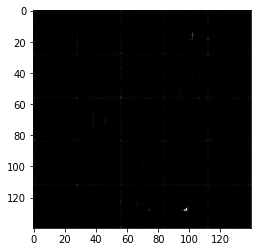

Epoch 1/2 ,  Batch 110 ,  Generator Loss: 0.2273 ,  Discriminator Loss: 2.0699
Epoch 1/2 ,  Batch 120 ,  Generator Loss: 0.2424 ,  Discriminator Loss: 2.1590
Epoch 1/2 ,  Batch 130 ,  Generator Loss: 0.2727 ,  Discriminator Loss: 1.9884
Epoch 1/2 ,  Batch 140 ,  Generator Loss: 0.3634 ,  Discriminator Loss: 1.7206
Epoch 1/2 ,  Batch 150 ,  Generator Loss: 0.3108 ,  Discriminator Loss: 1.7773
Epoch 1/2 ,  Batch 160 ,  Generator Loss: 0.2279 ,  Discriminator Loss: 2.0261
Epoch 1/2 ,  Batch 170 ,  Generator Loss: 0.2874 ,  Discriminator Loss: 1.8387
Epoch 1/2 ,  Batch 180 ,  Generator Loss: 0.3127 ,  Discriminator Loss: 1.7612
Epoch 1/2 ,  Batch 190 ,  Generator Loss: 0.3597 ,  Discriminator Loss: 1.6226
Epoch 1/2 ,  Batch 200 ,  Generator Loss: 0.2681 ,  Discriminator Loss: 1.9927


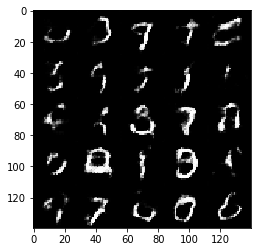

Epoch 1/2 ,  Batch 210 ,  Generator Loss: 0.4595 ,  Discriminator Loss: 1.4271
Epoch 1/2 ,  Batch 220 ,  Generator Loss: 0.2864 ,  Discriminator Loss: 1.8402
Epoch 1/2 ,  Batch 230 ,  Generator Loss: 0.2659 ,  Discriminator Loss: 1.9423
Epoch 1/2 ,  Batch 240 ,  Generator Loss: 0.4148 ,  Discriminator Loss: 1.5912
Epoch 1/2 ,  Batch 250 ,  Generator Loss: 0.3351 ,  Discriminator Loss: 1.7690
Epoch 1/2 ,  Batch 260 ,  Generator Loss: 0.3437 ,  Discriminator Loss: 1.8224
Epoch 1/2 ,  Batch 270 ,  Generator Loss: 0.2954 ,  Discriminator Loss: 1.8485
Epoch 1/2 ,  Batch 280 ,  Generator Loss: 0.2562 ,  Discriminator Loss: 2.0439
Epoch 1/2 ,  Batch 290 ,  Generator Loss: 0.2208 ,  Discriminator Loss: 2.0974
Epoch 1/2 ,  Batch 300 ,  Generator Loss: 0.2379 ,  Discriminator Loss: 2.0738


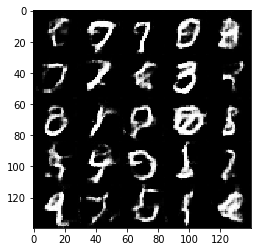

Epoch 1/2 ,  Batch 310 ,  Generator Loss: 0.2450 ,  Discriminator Loss: 2.0856
Epoch 1/2 ,  Batch 320 ,  Generator Loss: 0.2909 ,  Discriminator Loss: 1.8920
Epoch 1/2 ,  Batch 330 ,  Generator Loss: 0.2627 ,  Discriminator Loss: 2.0048
Epoch 1/2 ,  Batch 340 ,  Generator Loss: 0.2878 ,  Discriminator Loss: 1.8731
Epoch 1/2 ,  Batch 350 ,  Generator Loss: 0.3563 ,  Discriminator Loss: 1.6873
Epoch 1/2 ,  Batch 360 ,  Generator Loss: 0.3697 ,  Discriminator Loss: 1.6792
Epoch 1/2 ,  Batch 370 ,  Generator Loss: 0.2989 ,  Discriminator Loss: 1.9354
Epoch 1/2 ,  Batch 380 ,  Generator Loss: 0.3305 ,  Discriminator Loss: 1.7342
Epoch 1/2 ,  Batch 390 ,  Generator Loss: 0.3060 ,  Discriminator Loss: 1.8958
Epoch 1/2 ,  Batch 400 ,  Generator Loss: 0.3634 ,  Discriminator Loss: 1.6948


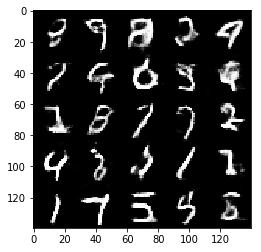

Epoch 1/2 ,  Batch 410 ,  Generator Loss: 0.4245 ,  Discriminator Loss: 1.6176
Epoch 1/2 ,  Batch 420 ,  Generator Loss: 0.3026 ,  Discriminator Loss: 1.8680
Epoch 1/2 ,  Batch 430 ,  Generator Loss: 0.4203 ,  Discriminator Loss: 1.5772
Epoch 1/2 ,  Batch 440 ,  Generator Loss: 0.3719 ,  Discriminator Loss: 1.6163
Epoch 1/2 ,  Batch 450 ,  Generator Loss: 0.3185 ,  Discriminator Loss: 1.8350
Epoch 1/2 ,  Batch 460 ,  Generator Loss: 0.3021 ,  Discriminator Loss: 1.8893
Epoch 1/2 ,  Batch 470 ,  Generator Loss: 0.3530 ,  Discriminator Loss: 1.7021
Epoch 1/2 ,  Batch 480 ,  Generator Loss: 0.2007 ,  Discriminator Loss: 2.1784
Epoch 1/2 ,  Batch 490 ,  Generator Loss: 0.4897 ,  Discriminator Loss: 1.4491
Epoch 1/2 ,  Batch 500 ,  Generator Loss: 0.2841 ,  Discriminator Loss: 1.9295


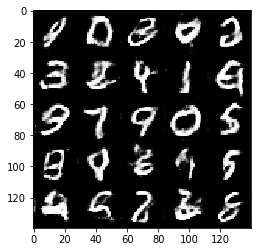

Epoch 1/2 ,  Batch 510 ,  Generator Loss: 0.3691 ,  Discriminator Loss: 1.6858
Epoch 1/2 ,  Batch 520 ,  Generator Loss: 0.3375 ,  Discriminator Loss: 1.7427
Epoch 1/2 ,  Batch 530 ,  Generator Loss: 0.3680 ,  Discriminator Loss: 1.7055
Epoch 1/2 ,  Batch 540 ,  Generator Loss: 0.3027 ,  Discriminator Loss: 1.8219
Epoch 1/2 ,  Batch 550 ,  Generator Loss: 0.2822 ,  Discriminator Loss: 1.9605
Epoch 1/2 ,  Batch 560 ,  Generator Loss: 0.3605 ,  Discriminator Loss: 1.7726
Epoch 1/2 ,  Batch 570 ,  Generator Loss: 0.3621 ,  Discriminator Loss: 1.7373
Epoch 1/2 ,  Batch 580 ,  Generator Loss: 0.5019 ,  Discriminator Loss: 1.5059
Epoch 1/2 ,  Batch 590 ,  Generator Loss: 0.3769 ,  Discriminator Loss: 1.6595
Epoch 1/2 ,  Batch 600 ,  Generator Loss: 0.5050 ,  Discriminator Loss: 1.4202


Epoch 1/2 ,  Batch 610 ,  Generator Loss: 0.3366 ,  Discriminator Loss: 1.8116
Epoch 1/2 ,  Batch 620 ,  Generator Loss: 0.5291 ,  Discriminator Loss: 1.3737
Epoch 1/2 ,  Batch 630 ,  Generator Loss: 0.2283 ,  Discriminator Loss: 2.1137
Epoch 1/2 ,  Batch 640 ,  Generator Loss: 0.4462 ,  Discriminator Loss: 1.5852
Epoch 1/2 ,  Batch 650 ,  Generator Loss: 1.5309 ,  Discriminator Loss: 1.0327
Epoch 1/2 ,  Batch 660 ,  Generator Loss: 1.4726 ,  Discriminator Loss: 1.1557
Epoch 1/2 ,  Batch 670 ,  Generator Loss: 1.3230 ,  Discriminator Loss: 1.0952
Epoch 1/2 ,  Batch 680 ,  Generator Loss: 1.4633 ,  Discriminator Loss: 0.9178
Epoch 1/2 ,  Batch 690 ,  Generator Loss: 1.9148 ,  Discriminator Loss: 1.2906
Epoch 1/2 ,  Batch 700 ,  Generator Loss: 1.4293 ,  Discriminator Loss: 1.2028


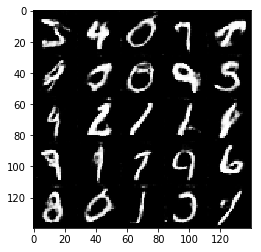

Epoch 1/2 ,  Batch 710 ,  Generator Loss: 1.9887 ,  Discriminator Loss: 1.3428
Epoch 1/2 ,  Batch 720 ,  Generator Loss: 1.6537 ,  Discriminator Loss: 1.1705
Epoch 1/2 ,  Batch 730 ,  Generator Loss: 1.9802 ,  Discriminator Loss: 0.9899
Epoch 1/2 ,  Batch 740 ,  Generator Loss: 2.2494 ,  Discriminator Loss: 1.0273
Epoch 1/2 ,  Batch 750 ,  Generator Loss: 2.3674 ,  Discriminator Loss: 1.6083
Epoch 1/2 ,  Batch 760 ,  Generator Loss: 1.7388 ,  Discriminator Loss: 1.2176
Epoch 1/2 ,  Batch 770 ,  Generator Loss: 2.0228 ,  Discriminator Loss: 1.2617
Epoch 1/2 ,  Batch 780 ,  Generator Loss: 1.9296 ,  Discriminator Loss: 1.2818
Epoch 1/2 ,  Batch 790 ,  Generator Loss: 0.3822 ,  Discriminator Loss: 1.8294
Epoch 1/2 ,  Batch 800 ,  Generator Loss: 0.3730 ,  Discriminator Loss: 1.7315


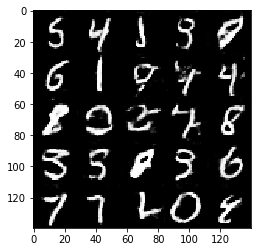

Epoch 1/2 ,  Batch 810 ,  Generator Loss: 0.2545 ,  Discriminator Loss: 2.2140
Epoch 1/2 ,  Batch 820 ,  Generator Loss: 1.7099 ,  Discriminator Loss: 0.9793
Epoch 1/2 ,  Batch 830 ,  Generator Loss: 1.9394 ,  Discriminator Loss: 1.2817
Epoch 1/2 ,  Batch 840 ,  Generator Loss: 1.9985 ,  Discriminator Loss: 1.2945
Epoch 1/2 ,  Batch 850 ,  Generator Loss: 2.5076 ,  Discriminator Loss: 1.1083
Epoch 1/2 ,  Batch 860 ,  Generator Loss: 1.4314 ,  Discriminator Loss: 0.9508
Epoch 1/2 ,  Batch 870 ,  Generator Loss: 1.5115 ,  Discriminator Loss: 1.2344
Epoch 1/2 ,  Batch 880 ,  Generator Loss: 1.5811 ,  Discriminator Loss: 1.0913
Epoch 1/2 ,  Batch 890 ,  Generator Loss: 2.7221 ,  Discriminator Loss: 1.6235
Epoch 1/2 ,  Batch 900 ,  Generator Loss: 2.9186 ,  Discriminator Loss: 1.6941


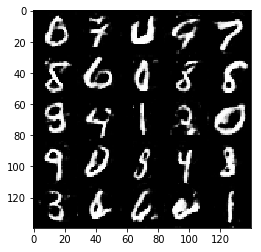

Epoch 1/2 ,  Batch 910 ,  Generator Loss: 0.5364 ,  Discriminator Loss: 1.4438
Epoch 1/2 ,  Batch 920 ,  Generator Loss: 0.7059 ,  Discriminator Loss: 1.2747
Epoch 1/2 ,  Batch 930 ,  Generator Loss: 0.4396 ,  Discriminator Loss: 1.6110
Epoch 2/2 ,  Batch 940 ,  Generator Loss: 0.5582 ,  Discriminator Loss: 1.3801
Epoch 2/2 ,  Batch 950 ,  Generator Loss: 0.4511 ,  Discriminator Loss: 1.7244
Epoch 2/2 ,  Batch 960 ,  Generator Loss: 1.4789 ,  Discriminator Loss: 0.8272
Epoch 2/2 ,  Batch 970 ,  Generator Loss: 0.8170 ,  Discriminator Loss: 1.1945
Epoch 2/2 ,  Batch 980 ,  Generator Loss: 2.2240 ,  Discriminator Loss: 1.6329
Epoch 2/2 ,  Batch 990 ,  Generator Loss: 2.1363 ,  Discriminator Loss: 0.9570
Epoch 2/2 ,  Batch 1000 ,  Generator Loss: 1.9765 ,  Discriminator Loss: 1.0449


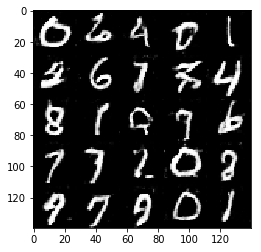

Epoch 2/2 ,  Batch 1010 ,  Generator Loss: 1.6817 ,  Discriminator Loss: 0.9594
Epoch 2/2 ,  Batch 1020 ,  Generator Loss: 2.0252 ,  Discriminator Loss: 1.1515
Epoch 2/2 ,  Batch 1030 ,  Generator Loss: 1.6169 ,  Discriminator Loss: 1.0316
Epoch 2/2 ,  Batch 1040 ,  Generator Loss: 1.6389 ,  Discriminator Loss: 0.7564
Epoch 2/2 ,  Batch 1050 ,  Generator Loss: 1.6847 ,  Discriminator Loss: 1.1175
Epoch 2/2 ,  Batch 1060 ,  Generator Loss: 1.4416 ,  Discriminator Loss: 0.8912
Epoch 2/2 ,  Batch 1070 ,  Generator Loss: 2.8145 ,  Discriminator Loss: 1.2874
Epoch 2/2 ,  Batch 1080 ,  Generator Loss: 2.7180 ,  Discriminator Loss: 1.1236
Epoch 2/2 ,  Batch 1090 ,  Generator Loss: 1.9915 ,  Discriminator Loss: 1.1716
Epoch 2/2 ,  Batch 1100 ,  Generator Loss: 2.5763 ,  Discriminator Loss: 1.3432


Epoch 2/2 ,  Batch 1110 ,  Generator Loss: 0.5905 ,  Discriminator Loss: 1.3685
Epoch 2/2 ,  Batch 1120 ,  Generator Loss: 0.5364 ,  Discriminator Loss: 1.4582
Epoch 2/2 ,  Batch 1130 ,  Generator Loss: 0.4757 ,  Discriminator Loss: 1.5426
Epoch 2/2 ,  Batch 1140 ,  Generator Loss: 0.8894 ,  Discriminator Loss: 1.0807
Epoch 2/2 ,  Batch 1150 ,  Generator Loss: 0.4923 ,  Discriminator Loss: 1.5267
Epoch 2/2 ,  Batch 1160 ,  Generator Loss: 0.6747 ,  Discriminator Loss: 1.2616
Epoch 2/2 ,  Batch 1170 ,  Generator Loss: 1.2174 ,  Discriminator Loss: 0.7686
Epoch 2/2 ,  Batch 1180 ,  Generator Loss: 0.5062 ,  Discriminator Loss: 1.4629
Epoch 2/2 ,  Batch 1190 ,  Generator Loss: 2.3977 ,  Discriminator Loss: 0.8052
Epoch 2/2 ,  Batch 1200 ,  Generator Loss: 1.8753 ,  Discriminator Loss: 0.7979


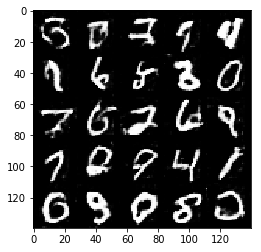

Epoch 2/2 ,  Batch 1210 ,  Generator Loss: 2.1035 ,  Discriminator Loss: 1.1569
Epoch 2/2 ,  Batch 1220 ,  Generator Loss: 1.8382 ,  Discriminator Loss: 0.8840
Epoch 2/2 ,  Batch 1230 ,  Generator Loss: 2.0526 ,  Discriminator Loss: 1.0675
Epoch 2/2 ,  Batch 1240 ,  Generator Loss: 1.8690 ,  Discriminator Loss: 0.8086
Epoch 2/2 ,  Batch 1250 ,  Generator Loss: 2.5474 ,  Discriminator Loss: 1.4347
Epoch 2/2 ,  Batch 1260 ,  Generator Loss: 2.1468 ,  Discriminator Loss: 0.9777
Epoch 2/2 ,  Batch 1270 ,  Generator Loss: 1.8030 ,  Discriminator Loss: 0.7399
Epoch 2/2 ,  Batch 1280 ,  Generator Loss: 0.2770 ,  Discriminator Loss: 2.1636
Epoch 2/2 ,  Batch 1290 ,  Generator Loss: 1.3690 ,  Discriminator Loss: 0.8366
Epoch 2/2 ,  Batch 1300 ,  Generator Loss: 2.3869 ,  Discriminator Loss: 1.3101


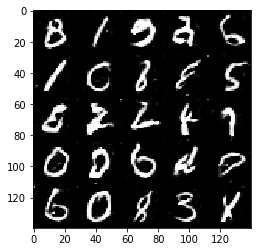

Epoch 2/2 ,  Batch 1310 ,  Generator Loss: 2.6902 ,  Discriminator Loss: 0.9062
Epoch 2/2 ,  Batch 1320 ,  Generator Loss: 1.7037 ,  Discriminator Loss: 0.7176
Epoch 2/2 ,  Batch 1330 ,  Generator Loss: 0.3965 ,  Discriminator Loss: 1.9152
Epoch 2/2 ,  Batch 1340 ,  Generator Loss: 0.9866 ,  Discriminator Loss: 1.1544
Epoch 2/2 ,  Batch 1350 ,  Generator Loss: 3.0833 ,  Discriminator Loss: 1.1206
Epoch 2/2 ,  Batch 1360 ,  Generator Loss: 1.1757 ,  Discriminator Loss: 0.8539
Epoch 2/2 ,  Batch 1370 ,  Generator Loss: 0.7881 ,  Discriminator Loss: 1.2387
Epoch 2/2 ,  Batch 1380 ,  Generator Loss: 2.2814 ,  Discriminator Loss: 0.8236
Epoch 2/2 ,  Batch 1390 ,  Generator Loss: 0.4147 ,  Discriminator Loss: 1.8768
Epoch 2/2 ,  Batch 1400 ,  Generator Loss: 0.5643 ,  Discriminator Loss: 1.5216


Epoch 2/2 ,  Batch 1410 ,  Generator Loss: 1.3409 ,  Discriminator Loss: 0.8613
Epoch 2/2 ,  Batch 1420 ,  Generator Loss: 0.5360 ,  Discriminator Loss: 1.8769
Epoch 2/2 ,  Batch 1430 ,  Generator Loss: 0.8784 ,  Discriminator Loss: 1.2121
Epoch 2/2 ,  Batch 1440 ,  Generator Loss: 0.5349 ,  Discriminator Loss: 1.4385
Epoch 2/2 ,  Batch 1450 ,  Generator Loss: 1.7875 ,  Discriminator Loss: 0.9101
Epoch 2/2 ,  Batch 1460 ,  Generator Loss: 1.4666 ,  Discriminator Loss: 0.9020
Epoch 2/2 ,  Batch 1470 ,  Generator Loss: 0.5265 ,  Discriminator Loss: 1.5610
Epoch 2/2 ,  Batch 1480 ,  Generator Loss: 3.1223 ,  Discriminator Loss: 1.2842
Epoch 2/2 ,  Batch 1490 ,  Generator Loss: 2.0623 ,  Discriminator Loss: 0.5608
Epoch 2/2 ,  Batch 1500 ,  Generator Loss: 1.1917 ,  Discriminator Loss: 0.9651


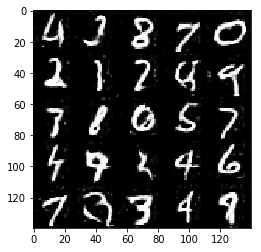

Epoch 2/2 ,  Batch 1510 ,  Generator Loss: 0.6051 ,  Discriminator Loss: 1.4965
Epoch 2/2 ,  Batch 1520 ,  Generator Loss: 1.0327 ,  Discriminator Loss: 1.1955
Epoch 2/2 ,  Batch 1530 ,  Generator Loss: 1.3581 ,  Discriminator Loss: 0.7482
Epoch 2/2 ,  Batch 1540 ,  Generator Loss: 1.8780 ,  Discriminator Loss: 0.7241
Epoch 2/2 ,  Batch 1550 ,  Generator Loss: 1.5733 ,  Discriminator Loss: 0.9728
Epoch 2/2 ,  Batch 1560 ,  Generator Loss: 1.3199 ,  Discriminator Loss: 0.8732
Epoch 2/2 ,  Batch 1570 ,  Generator Loss: 0.8384 ,  Discriminator Loss: 1.0755
Epoch 2/2 ,  Batch 1580 ,  Generator Loss: 2.4430 ,  Discriminator Loss: 0.8375
Epoch 2/2 ,  Batch 1590 ,  Generator Loss: 3.2003 ,  Discriminator Loss: 1.8044
Epoch 2/2 ,  Batch 1600 ,  Generator Loss: 0.8295 ,  Discriminator Loss: 1.2423


Epoch 2/2 ,  Batch 1610 ,  Generator Loss: 1.1001 ,  Discriminator Loss: 0.9447
Epoch 2/2 ,  Batch 1620 ,  Generator Loss: 0.7337 ,  Discriminator Loss: 1.1914
Epoch 2/2 ,  Batch 1630 ,  Generator Loss: 0.6647 ,  Discriminator Loss: 1.2795
Epoch 2/2 ,  Batch 1640 ,  Generator Loss: 1.0606 ,  Discriminator Loss: 1.0939
Epoch 2/2 ,  Batch 1650 ,  Generator Loss: 2.4985 ,  Discriminator Loss: 1.0227
Epoch 2/2 ,  Batch 1660 ,  Generator Loss: 2.0642 ,  Discriminator Loss: 0.9222
Epoch 2/2 ,  Batch 1670 ,  Generator Loss: 1.9445 ,  Discriminator Loss: 0.7971
Epoch 2/2 ,  Batch 1680 ,  Generator Loss: 2.2407 ,  Discriminator Loss: 0.7217
Epoch 2/2 ,  Batch 1690 ,  Generator Loss: 1.0393 ,  Discriminator Loss: 1.2454
Epoch 2/2 ,  Batch 1700 ,  Generator Loss: 0.6826 ,  Discriminator Loss: 1.3746


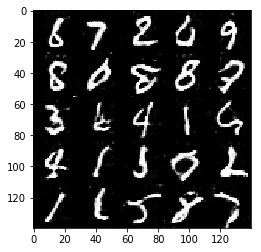

Epoch 2/2 ,  Batch 1710 ,  Generator Loss: 0.3466 ,  Discriminator Loss: 2.1590
Epoch 2/2 ,  Batch 1720 ,  Generator Loss: 2.2802 ,  Discriminator Loss: 0.6348
Epoch 2/2 ,  Batch 1730 ,  Generator Loss: 1.8518 ,  Discriminator Loss: 0.6166
Epoch 2/2 ,  Batch 1740 ,  Generator Loss: 0.3222 ,  Discriminator Loss: 2.3773
Epoch 2/2 ,  Batch 1750 ,  Generator Loss: 2.7352 ,  Discriminator Loss: 0.8488
Epoch 2/2 ,  Batch 1760 ,  Generator Loss: 0.6548 ,  Discriminator Loss: 1.7992
Epoch 2/2 ,  Batch 1770 ,  Generator Loss: 1.9051 ,  Discriminator Loss: 0.6158
Epoch 2/2 ,  Batch 1780 ,  Generator Loss: 3.3968 ,  Discriminator Loss: 1.2600
Epoch 2/2 ,  Batch 1790 ,  Generator Loss: 2.4990 ,  Discriminator Loss: 0.8723
Epoch 2/2 ,  Batch 1800 ,  Generator Loss: 0.8841 ,  Discriminator Loss: 1.2925


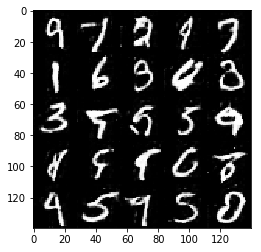

Epoch 2/2 ,  Batch 1810 ,  Generator Loss: 1.4251 ,  Discriminator Loss: 0.7166
Epoch 2/2 ,  Batch 1820 ,  Generator Loss: 2.8771 ,  Discriminator Loss: 1.2839
Epoch 2/2 ,  Batch 1830 ,  Generator Loss: 2.8744 ,  Discriminator Loss: 0.5668
Epoch 2/2 ,  Batch 1840 ,  Generator Loss: 1.4477 ,  Discriminator Loss: 0.7952
Epoch 2/2 ,  Batch 1850 ,  Generator Loss: 1.4343 ,  Discriminator Loss: 0.8186
Epoch 2/2 ,  Batch 1860 ,  Generator Loss: 0.3433 ,  Discriminator Loss: 2.0121
Epoch 2/2 ,  Batch 1870 ,  Generator Loss: 1.5901 ,  Discriminator Loss: 0.8740


In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches
          ,mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 ,  Batch 10 ,  Generator Loss: 5.4209 ,  Discriminator Loss: 0.4204
Epoch 1/1 ,  Batch 20 ,  Generator Loss: 0.7137 ,  Discriminator Loss: 1.4213
Epoch 1/1 ,  Batch 30 ,  Generator Loss: 6.5130 ,  Discriminator Loss: 0.3768
Epoch 1/1 ,  Batch 40 ,  Generator Loss: 0.0535 ,  Discriminator Loss: 4.7124
Epoch 1/1 ,  Batch 50 ,  Generator Loss: 1.2980 ,  Discriminator Loss: 0.8814
Epoch 1/1 ,  Batch 60 ,  Generator Loss: 7.8617 ,  Discriminator Loss: 2.6709
Epoch 1/1 ,  Batch 70 ,  Generator Loss: 3.3610 ,  Discriminator Loss: 0.4841
Epoch 1/1 ,  Batch 80 ,  Generator Loss: 2.0250 ,  Discriminator Loss: 0.5668
Epoch 1/1 ,  Batch 90 ,  Generator Loss: 0.7804 ,  Discriminator Loss: 1.3892
Epoch 1/1 ,  Batch 100 ,  Generator Loss: 0.1947 ,  Discriminator Loss: 2.5300


Epoch 1/1 ,  Batch 110 ,  Generator Loss: 0.3350 ,  Discriminator Loss: 2.1816
Epoch 1/1 ,  Batch 120 ,  Generator Loss: 0.3364 ,  Discriminator Loss: 2.0546
Epoch 1/1 ,  Batch 130 ,  Generator Loss: 0.0604 ,  Discriminator Loss: 3.4275
Epoch 1/1 ,  Batch 140 ,  Generator Loss: 4.5922 ,  Discriminator Loss: 2.9206
Epoch 1/1 ,  Batch 150 ,  Generator Loss: 0.3518 ,  Discriminator Loss: 1.8540
Epoch 1/1 ,  Batch 160 ,  Generator Loss: 2.1757 ,  Discriminator Loss: 1.1628
Epoch 1/1 ,  Batch 170 ,  Generator Loss: 1.3476 ,  Discriminator Loss: 1.0496
Epoch 1/1 ,  Batch 180 ,  Generator Loss: 2.6966 ,  Discriminator Loss: 2.1913
Epoch 1/1 ,  Batch 190 ,  Generator Loss: 0.3593 ,  Discriminator Loss: 1.9583
Epoch 1/1 ,  Batch 200 ,  Generator Loss: 0.2449 ,  Discriminator Loss: 2.1234


Epoch 1/1 ,  Batch 210 ,  Generator Loss: 0.2294 ,  Discriminator Loss: 2.2380
Epoch 1/1 ,  Batch 220 ,  Generator Loss: 1.4012 ,  Discriminator Loss: 1.2583
Epoch 1/1 ,  Batch 230 ,  Generator Loss: 1.2504 ,  Discriminator Loss: 1.0861
Epoch 1/1 ,  Batch 240 ,  Generator Loss: 2.1967 ,  Discriminator Loss: 1.7531
Epoch 1/1 ,  Batch 250 ,  Generator Loss: 3.4098 ,  Discriminator Loss: 2.3676
Epoch 1/1 ,  Batch 260 ,  Generator Loss: 0.8275 ,  Discriminator Loss: 1.0677
Epoch 1/1 ,  Batch 270 ,  Generator Loss: 0.1275 ,  Discriminator Loss: 2.7846
Epoch 1/1 ,  Batch 280 ,  Generator Loss: 1.3007 ,  Discriminator Loss: 1.6292
Epoch 1/1 ,  Batch 290 ,  Generator Loss: 0.1167 ,  Discriminator Loss: 2.9067
Epoch 1/1 ,  Batch 300 ,  Generator Loss: 0.1778 ,  Discriminator Loss: 2.3593


Epoch 1/1 ,  Batch 310 ,  Generator Loss: 0.1824 ,  Discriminator Loss: 2.3771
Epoch 1/1 ,  Batch 320 ,  Generator Loss: 0.3525 ,  Discriminator Loss: 1.6089
Epoch 1/1 ,  Batch 330 ,  Generator Loss: 0.1265 ,  Discriminator Loss: 2.5971
Epoch 1/1 ,  Batch 340 ,  Generator Loss: 1.9205 ,  Discriminator Loss: 1.8149
Epoch 1/1 ,  Batch 350 ,  Generator Loss: 3.0994 ,  Discriminator Loss: 2.8971
Epoch 1/1 ,  Batch 360 ,  Generator Loss: 0.8834 ,  Discriminator Loss: 1.7562
Epoch 1/1 ,  Batch 370 ,  Generator Loss: 1.0830 ,  Discriminator Loss: 1.4252
Epoch 1/1 ,  Batch 380 ,  Generator Loss: 1.0610 ,  Discriminator Loss: 1.6678
Epoch 1/1 ,  Batch 390 ,  Generator Loss: 1.0429 ,  Discriminator Loss: 1.2498
Epoch 1/1 ,  Batch 400 ,  Generator Loss: 1.1494 ,  Discriminator Loss: 1.1150


Epoch 1/1 ,  Batch 410 ,  Generator Loss: 1.7124 ,  Discriminator Loss: 1.8218
Epoch 1/1 ,  Batch 420 ,  Generator Loss: 0.2766 ,  Discriminator Loss: 1.9125
Epoch 1/1 ,  Batch 430 ,  Generator Loss: 0.3079 ,  Discriminator Loss: 1.8729
Epoch 1/1 ,  Batch 440 ,  Generator Loss: 0.2786 ,  Discriminator Loss: 1.8415
Epoch 1/1 ,  Batch 450 ,  Generator Loss: 0.3882 ,  Discriminator Loss: 1.6460
Epoch 1/1 ,  Batch 460 ,  Generator Loss: 0.4299 ,  Discriminator Loss: 1.5950
Epoch 1/1 ,  Batch 470 ,  Generator Loss: 0.2539 ,  Discriminator Loss: 1.9306
Epoch 1/1 ,  Batch 480 ,  Generator Loss: 0.2888 ,  Discriminator Loss: 1.8830
Epoch 1/1 ,  Batch 490 ,  Generator Loss: 0.5006 ,  Discriminator Loss: 1.4743
Epoch 1/1 ,  Batch 500 ,  Generator Loss: 0.5789 ,  Discriminator Loss: 1.5590


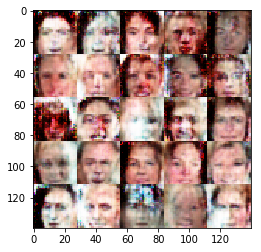

Epoch 1/1 ,  Batch 510 ,  Generator Loss: 1.1734 ,  Discriminator Loss: 1.2040
Epoch 1/1 ,  Batch 520 ,  Generator Loss: 0.1377 ,  Discriminator Loss: 2.4398
Epoch 1/1 ,  Batch 530 ,  Generator Loss: 0.3299 ,  Discriminator Loss: 1.7849
Epoch 1/1 ,  Batch 540 ,  Generator Loss: 0.3338 ,  Discriminator Loss: 1.8002
Epoch 1/1 ,  Batch 550 ,  Generator Loss: 0.2610 ,  Discriminator Loss: 1.9083
Epoch 1/1 ,  Batch 560 ,  Generator Loss: 0.1566 ,  Discriminator Loss: 2.3011
Epoch 1/1 ,  Batch 570 ,  Generator Loss: 0.1756 ,  Discriminator Loss: 2.2738
Epoch 1/1 ,  Batch 580 ,  Generator Loss: 0.3207 ,  Discriminator Loss: 1.7436
Epoch 1/1 ,  Batch 590 ,  Generator Loss: 0.4875 ,  Discriminator Loss: 1.5545
Epoch 1/1 ,  Batch 600 ,  Generator Loss: 1.4420 ,  Discriminator Loss: 1.6439


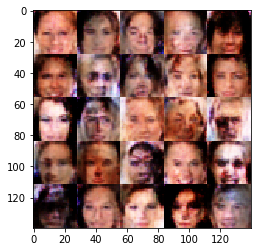

Epoch 1/1 ,  Batch 610 ,  Generator Loss: 0.4112 ,  Discriminator Loss: 1.6586
Epoch 1/1 ,  Batch 620 ,  Generator Loss: 0.3411 ,  Discriminator Loss: 1.7269
Epoch 1/1 ,  Batch 630 ,  Generator Loss: 0.4647 ,  Discriminator Loss: 1.5916
Epoch 1/1 ,  Batch 640 ,  Generator Loss: 0.3512 ,  Discriminator Loss: 1.7035
Epoch 1/1 ,  Batch 650 ,  Generator Loss: 0.1912 ,  Discriminator Loss: 2.2479
Epoch 1/1 ,  Batch 660 ,  Generator Loss: 1.0005 ,  Discriminator Loss: 1.4853
Epoch 1/1 ,  Batch 670 ,  Generator Loss: 0.7653 ,  Discriminator Loss: 1.3600
Epoch 1/1 ,  Batch 680 ,  Generator Loss: 0.3580 ,  Discriminator Loss: 1.7086
Epoch 1/1 ,  Batch 690 ,  Generator Loss: 0.3945 ,  Discriminator Loss: 1.6319
Epoch 1/1 ,  Batch 700 ,  Generator Loss: 0.2628 ,  Discriminator Loss: 1.9164


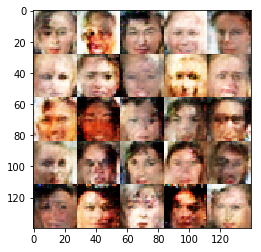

Epoch 1/1 ,  Batch 710 ,  Generator Loss: 0.2306 ,  Discriminator Loss: 2.1270
Epoch 1/1 ,  Batch 720 ,  Generator Loss: 0.3392 ,  Discriminator Loss: 1.7576
Epoch 1/1 ,  Batch 730 ,  Generator Loss: 0.6428 ,  Discriminator Loss: 1.4130
Epoch 1/1 ,  Batch 740 ,  Generator Loss: 1.3944 ,  Discriminator Loss: 1.4532
Epoch 1/1 ,  Batch 750 ,  Generator Loss: 0.7868 ,  Discriminator Loss: 1.3958
Epoch 1/1 ,  Batch 760 ,  Generator Loss: 0.8293 ,  Discriminator Loss: 1.4058
Epoch 1/1 ,  Batch 770 ,  Generator Loss: 0.3237 ,  Discriminator Loss: 1.7246
Epoch 1/1 ,  Batch 780 ,  Generator Loss: 0.5014 ,  Discriminator Loss: 1.4279
Epoch 1/1 ,  Batch 790 ,  Generator Loss: 0.3221 ,  Discriminator Loss: 1.7978
Epoch 1/1 ,  Batch 800 ,  Generator Loss: 0.3109 ,  Discriminator Loss: 1.7660


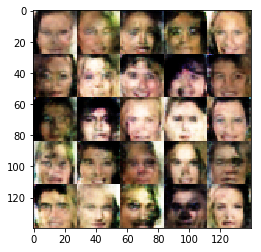

Epoch 1/1 ,  Batch 810 ,  Generator Loss: 0.2232 ,  Discriminator Loss: 2.0259
Epoch 1/1 ,  Batch 820 ,  Generator Loss: 0.3940 ,  Discriminator Loss: 1.6282
Epoch 1/1 ,  Batch 830 ,  Generator Loss: 0.5149 ,  Discriminator Loss: 1.4688
Epoch 1/1 ,  Batch 840 ,  Generator Loss: 1.5955 ,  Discriminator Loss: 1.8620
Epoch 1/1 ,  Batch 850 ,  Generator Loss: 0.3832 ,  Discriminator Loss: 1.6555
Epoch 1/1 ,  Batch 860 ,  Generator Loss: 1.2360 ,  Discriminator Loss: 1.5413
Epoch 1/1 ,  Batch 870 ,  Generator Loss: 0.7124 ,  Discriminator Loss: 1.4205
Epoch 1/1 ,  Batch 880 ,  Generator Loss: 0.5138 ,  Discriminator Loss: 1.4785
Epoch 1/1 ,  Batch 890 ,  Generator Loss: 0.2604 ,  Discriminator Loss: 1.9856
Epoch 1/1 ,  Batch 900 ,  Generator Loss: 0.9033 ,  Discriminator Loss: 1.3238


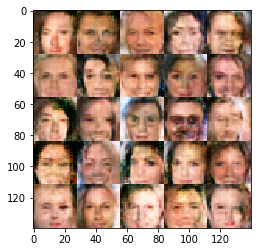

Epoch 1/1 ,  Batch 910 ,  Generator Loss: 0.3345 ,  Discriminator Loss: 1.6544
Epoch 1/1 ,  Batch 920 ,  Generator Loss: 0.4949 ,  Discriminator Loss: 1.4291
Epoch 1/1 ,  Batch 930 ,  Generator Loss: 1.2241 ,  Discriminator Loss: 1.5244
Epoch 1/1 ,  Batch 940 ,  Generator Loss: 0.8479 ,  Discriminator Loss: 1.3055
Epoch 1/1 ,  Batch 950 ,  Generator Loss: 0.9665 ,  Discriminator Loss: 1.3383
Epoch 1/1 ,  Batch 960 ,  Generator Loss: 0.5753 ,  Discriminator Loss: 1.4337
Epoch 1/1 ,  Batch 970 ,  Generator Loss: 0.4054 ,  Discriminator Loss: 1.5256
Epoch 1/1 ,  Batch 980 ,  Generator Loss: 0.8089 ,  Discriminator Loss: 1.4875
Epoch 1/1 ,  Batch 990 ,  Generator Loss: 0.9232 ,  Discriminator Loss: 1.3498
Epoch 1/1 ,  Batch 1000 ,  Generator Loss: 0.8028 ,  Discriminator Loss: 1.4370


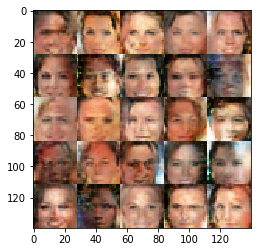

Epoch 1/1 ,  Batch 1010 ,  Generator Loss: 1.3948 ,  Discriminator Loss: 1.9063
Epoch 1/1 ,  Batch 1020 ,  Generator Loss: 1.0019 ,  Discriminator Loss: 1.2644
Epoch 1/1 ,  Batch 1030 ,  Generator Loss: 0.2999 ,  Discriminator Loss: 1.7559
Epoch 1/1 ,  Batch 1040 ,  Generator Loss: 0.2144 ,  Discriminator Loss: 2.1221
Epoch 1/1 ,  Batch 1050 ,  Generator Loss: 1.1185 ,  Discriminator Loss: 1.5349
Epoch 1/1 ,  Batch 1060 ,  Generator Loss: 0.2335 ,  Discriminator Loss: 1.9831
Epoch 1/1 ,  Batch 1070 ,  Generator Loss: 0.2290 ,  Discriminator Loss: 2.0983
Epoch 1/1 ,  Batch 1080 ,  Generator Loss: 0.3447 ,  Discriminator Loss: 1.7288
Epoch 1/1 ,  Batch 1090 ,  Generator Loss: 0.5658 ,  Discriminator Loss: 1.4129
Epoch 1/1 ,  Batch 1100 ,  Generator Loss: 0.6189 ,  Discriminator Loss: 1.4422


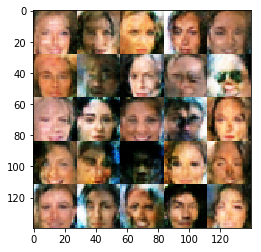

Epoch 1/1 ,  Batch 1110 ,  Generator Loss: 1.4567 ,  Discriminator Loss: 1.7711
Epoch 1/1 ,  Batch 1120 ,  Generator Loss: 0.4099 ,  Discriminator Loss: 1.5567
Epoch 1/1 ,  Batch 1130 ,  Generator Loss: 0.5629 ,  Discriminator Loss: 1.4259
Epoch 1/1 ,  Batch 1140 ,  Generator Loss: 0.3911 ,  Discriminator Loss: 1.6571
Epoch 1/1 ,  Batch 1150 ,  Generator Loss: 0.2923 ,  Discriminator Loss: 1.8125
Epoch 1/1 ,  Batch 1160 ,  Generator Loss: 0.1688 ,  Discriminator Loss: 2.3403
Epoch 1/1 ,  Batch 1170 ,  Generator Loss: 0.8710 ,  Discriminator Loss: 1.3074
Epoch 1/1 ,  Batch 1180 ,  Generator Loss: 1.4426 ,  Discriminator Loss: 1.6860
Epoch 1/1 ,  Batch 1190 ,  Generator Loss: 0.2973 ,  Discriminator Loss: 1.8018
Epoch 1/1 ,  Batch 1200 ,  Generator Loss: 0.3397 ,  Discriminator Loss: 1.7430


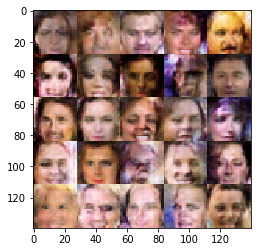

Epoch 1/1 ,  Batch 1210 ,  Generator Loss: 0.3850 ,  Discriminator Loss: 1.6545
Epoch 1/1 ,  Batch 1220 ,  Generator Loss: 0.4142 ,  Discriminator Loss: 1.5785
Epoch 1/1 ,  Batch 1230 ,  Generator Loss: 1.0116 ,  Discriminator Loss: 1.4981
Epoch 1/1 ,  Batch 1240 ,  Generator Loss: 0.2789 ,  Discriminator Loss: 1.7974
Epoch 1/1 ,  Batch 1250 ,  Generator Loss: 0.7823 ,  Discriminator Loss: 1.3765
Epoch 1/1 ,  Batch 1260 ,  Generator Loss: 0.8458 ,  Discriminator Loss: 1.3841
Epoch 1/1 ,  Batch 1270 ,  Generator Loss: 0.6819 ,  Discriminator Loss: 1.2253
Epoch 1/1 ,  Batch 1280 ,  Generator Loss: 0.3095 ,  Discriminator Loss: 1.7310
Epoch 1/1 ,  Batch 1290 ,  Generator Loss: 1.0003 ,  Discriminator Loss: 1.1037
Epoch 1/1 ,  Batch 1300 ,  Generator Loss: 0.8401 ,  Discriminator Loss: 1.1617


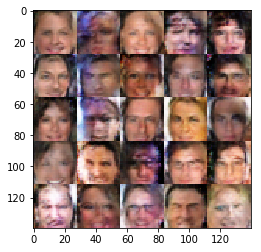

Epoch 1/1 ,  Batch 1310 ,  Generator Loss: 0.8900 ,  Discriminator Loss: 1.3588
Epoch 1/1 ,  Batch 1320 ,  Generator Loss: 0.3581 ,  Discriminator Loss: 1.6078
Epoch 1/1 ,  Batch 1330 ,  Generator Loss: 0.6446 ,  Discriminator Loss: 1.5692
Epoch 1/1 ,  Batch 1340 ,  Generator Loss: 0.6630 ,  Discriminator Loss: 1.4363
Epoch 1/1 ,  Batch 1350 ,  Generator Loss: 0.5422 ,  Discriminator Loss: 1.3442
Epoch 1/1 ,  Batch 1360 ,  Generator Loss: 0.4263 ,  Discriminator Loss: 1.5404
Epoch 1/1 ,  Batch 1370 ,  Generator Loss: 0.9257 ,  Discriminator Loss: 1.4133
Epoch 1/1 ,  Batch 1380 ,  Generator Loss: 0.5840 ,  Discriminator Loss: 1.4097
Epoch 1/1 ,  Batch 1390 ,  Generator Loss: 0.3335 ,  Discriminator Loss: 1.7093
Epoch 1/1 ,  Batch 1400 ,  Generator Loss: 0.3726 ,  Discriminator Loss: 1.6540


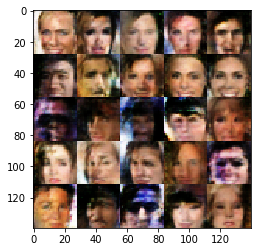

Epoch 1/1 ,  Batch 1410 ,  Generator Loss: 0.3189 ,  Discriminator Loss: 1.8418
Epoch 1/1 ,  Batch 1420 ,  Generator Loss: 0.2559 ,  Discriminator Loss: 1.9496
Epoch 1/1 ,  Batch 1430 ,  Generator Loss: 0.3737 ,  Discriminator Loss: 1.5790
Epoch 1/1 ,  Batch 1440 ,  Generator Loss: 0.8981 ,  Discriminator Loss: 1.3343
Epoch 1/1 ,  Batch 1450 ,  Generator Loss: 1.1736 ,  Discriminator Loss: 1.4814
Epoch 1/1 ,  Batch 1460 ,  Generator Loss: 0.8703 ,  Discriminator Loss: 1.4406
Epoch 1/1 ,  Batch 1470 ,  Generator Loss: 0.2575 ,  Discriminator Loss: 1.8678
Epoch 1/1 ,  Batch 1480 ,  Generator Loss: 0.5187 ,  Discriminator Loss: 1.3391
Epoch 1/1 ,  Batch 1490 ,  Generator Loss: 0.7995 ,  Discriminator Loss: 1.2073
Epoch 1/1 ,  Batch 1500 ,  Generator Loss: 0.4300 ,  Discriminator Loss: 1.6145


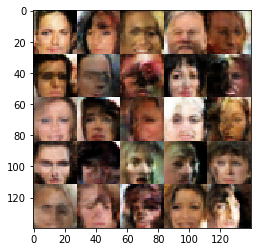

Epoch 1/1 ,  Batch 1510 ,  Generator Loss: 0.5800 ,  Discriminator Loss: 1.3947
Epoch 1/1 ,  Batch 1520 ,  Generator Loss: 0.7111 ,  Discriminator Loss: 1.3460
Epoch 1/1 ,  Batch 1530 ,  Generator Loss: 0.3989 ,  Discriminator Loss: 1.5442
Epoch 1/1 ,  Batch 1540 ,  Generator Loss: 0.9264 ,  Discriminator Loss: 1.3752
Epoch 1/1 ,  Batch 1550 ,  Generator Loss: 0.9585 ,  Discriminator Loss: 1.3154
Epoch 1/1 ,  Batch 1560 ,  Generator Loss: 0.5488 ,  Discriminator Loss: 1.5446
Epoch 1/1 ,  Batch 1570 ,  Generator Loss: 1.0452 ,  Discriminator Loss: 1.3088
Epoch 1/1 ,  Batch 1580 ,  Generator Loss: 0.4110 ,  Discriminator Loss: 1.5568
Epoch 1/1 ,  Batch 1590 ,  Generator Loss: 0.7621 ,  Discriminator Loss: 1.2927
Epoch 1/1 ,  Batch 1600 ,  Generator Loss: 0.2903 ,  Discriminator Loss: 1.8411


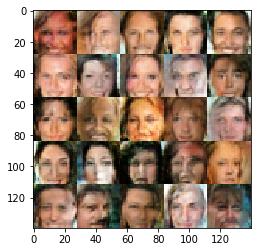

Epoch 1/1 ,  Batch 1610 ,  Generator Loss: 0.3242 ,  Discriminator Loss: 1.8090
Epoch 1/1 ,  Batch 1620 ,  Generator Loss: 0.5856 ,  Discriminator Loss: 1.3854
Epoch 1/1 ,  Batch 1630 ,  Generator Loss: 0.6559 ,  Discriminator Loss: 1.2496
Epoch 1/1 ,  Batch 1640 ,  Generator Loss: 0.3460 ,  Discriminator Loss: 1.7482
Epoch 1/1 ,  Batch 1650 ,  Generator Loss: 1.0189 ,  Discriminator Loss: 1.2611
Epoch 1/1 ,  Batch 1660 ,  Generator Loss: 1.1516 ,  Discriminator Loss: 1.3524
Epoch 1/1 ,  Batch 1670 ,  Generator Loss: 0.2327 ,  Discriminator Loss: 1.9887
Epoch 1/1 ,  Batch 1680 ,  Generator Loss: 0.3644 ,  Discriminator Loss: 1.5978
Epoch 1/1 ,  Batch 1690 ,  Generator Loss: 0.1917 ,  Discriminator Loss: 2.1070
Epoch 1/1 ,  Batch 1700 ,  Generator Loss: 1.5461 ,  Discriminator Loss: 1.6056


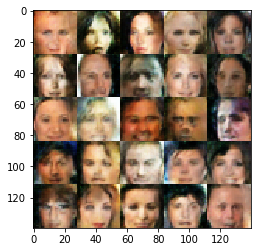

Epoch 1/1 ,  Batch 1710 ,  Generator Loss: 0.3554 ,  Discriminator Loss: 1.7791
Epoch 1/1 ,  Batch 1720 ,  Generator Loss: 1.7177 ,  Discriminator Loss: 1.7034
Epoch 1/1 ,  Batch 1730 ,  Generator Loss: 0.2873 ,  Discriminator Loss: 1.8122
Epoch 1/1 ,  Batch 1740 ,  Generator Loss: 0.2577 ,  Discriminator Loss: 2.0043
Epoch 1/1 ,  Batch 1750 ,  Generator Loss: 0.4176 ,  Discriminator Loss: 1.4970
Epoch 1/1 ,  Batch 1760 ,  Generator Loss: 0.3526 ,  Discriminator Loss: 1.6062
Epoch 1/1 ,  Batch 1770 ,  Generator Loss: 0.1926 ,  Discriminator Loss: 2.0816
Epoch 1/1 ,  Batch 1780 ,  Generator Loss: 1.2867 ,  Discriminator Loss: 1.4189
Epoch 1/1 ,  Batch 1790 ,  Generator Loss: 0.8914 ,  Discriminator Loss: 1.2606
Epoch 1/1 ,  Batch 1800 ,  Generator Loss: 0.6411 ,  Discriminator Loss: 1.4596


Epoch 1/1 ,  Batch 1810 ,  Generator Loss: 0.3283 ,  Discriminator Loss: 1.8013
Epoch 1/1 ,  Batch 1820 ,  Generator Loss: 0.3132 ,  Discriminator Loss: 1.7569
Epoch 1/1 ,  Batch 1830 ,  Generator Loss: 0.4902 ,  Discriminator Loss: 1.4965
Epoch 1/1 ,  Batch 1840 ,  Generator Loss: 0.2710 ,  Discriminator Loss: 1.9571
Epoch 1/1 ,  Batch 1850 ,  Generator Loss: 0.5373 ,  Discriminator Loss: 1.3603
Epoch 1/1 ,  Batch 1860 ,  Generator Loss: 0.3419 ,  Discriminator Loss: 1.6958
Epoch 1/1 ,  Batch 1870 ,  Generator Loss: 0.9432 ,  Discriminator Loss: 1.3607
Epoch 1/1 ,  Batch 1880 ,  Generator Loss: 0.4391 ,  Discriminator Loss: 1.4908
Epoch 1/1 ,  Batch 1890 ,  Generator Loss: 0.7433 ,  Discriminator Loss: 1.2982
Epoch 1/1 ,  Batch 1900 ,  Generator Loss: 0.6304 ,  Discriminator Loss: 1.3838


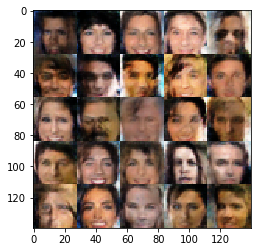

Epoch 1/1 ,  Batch 1910 ,  Generator Loss: 0.4410 ,  Discriminator Loss: 1.5417
Epoch 1/1 ,  Batch 1920 ,  Generator Loss: 1.4448 ,  Discriminator Loss: 1.4731
Epoch 1/1 ,  Batch 1930 ,  Generator Loss: 0.8184 ,  Discriminator Loss: 1.3100
Epoch 1/1 ,  Batch 1940 ,  Generator Loss: 0.7625 ,  Discriminator Loss: 1.2069
Epoch 1/1 ,  Batch 1950 ,  Generator Loss: 0.6938 ,  Discriminator Loss: 1.3588
Epoch 1/1 ,  Batch 1960 ,  Generator Loss: 0.9947 ,  Discriminator Loss: 1.2344
Epoch 1/1 ,  Batch 1970 ,  Generator Loss: 0.5539 ,  Discriminator Loss: 1.3202
Epoch 1/1 ,  Batch 1980 ,  Generator Loss: 0.1719 ,  Discriminator Loss: 2.2778
Epoch 1/1 ,  Batch 1990 ,  Generator Loss: 0.4749 ,  Discriminator Loss: 1.4902
Epoch 1/1 ,  Batch 2000 ,  Generator Loss: 0.4768 ,  Discriminator Loss: 1.4405


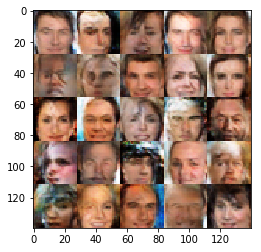

Epoch 1/1 ,  Batch 2010 ,  Generator Loss: 0.5301 ,  Discriminator Loss: 1.4677
Epoch 1/1 ,  Batch 2020 ,  Generator Loss: 0.2949 ,  Discriminator Loss: 1.8937
Epoch 1/1 ,  Batch 2030 ,  Generator Loss: 0.9063 ,  Discriminator Loss: 1.4245
Epoch 1/1 ,  Batch 2040 ,  Generator Loss: 0.7817 ,  Discriminator Loss: 1.2823
Epoch 1/1 ,  Batch 2050 ,  Generator Loss: 0.9527 ,  Discriminator Loss: 1.3189
Epoch 1/1 ,  Batch 2060 ,  Generator Loss: 0.5240 ,  Discriminator Loss: 1.3509
Epoch 1/1 ,  Batch 2070 ,  Generator Loss: 1.1049 ,  Discriminator Loss: 1.3605
Epoch 1/1 ,  Batch 2080 ,  Generator Loss: 1.4224 ,  Discriminator Loss: 1.3254
Epoch 1/1 ,  Batch 2090 ,  Generator Loss: 0.5193 ,  Discriminator Loss: 1.4076
Epoch 1/1 ,  Batch 2100 ,  Generator Loss: 1.1617 ,  Discriminator Loss: 1.0425


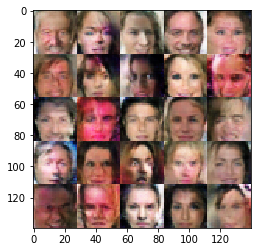

Epoch 1/1 ,  Batch 2110 ,  Generator Loss: 0.7301 ,  Discriminator Loss: 1.3585
Epoch 1/1 ,  Batch 2120 ,  Generator Loss: 0.4303 ,  Discriminator Loss: 1.5872
Epoch 1/1 ,  Batch 2130 ,  Generator Loss: 0.6021 ,  Discriminator Loss: 1.4500
Epoch 1/1 ,  Batch 2140 ,  Generator Loss: 0.4206 ,  Discriminator Loss: 1.4737
Epoch 1/1 ,  Batch 2150 ,  Generator Loss: 0.8866 ,  Discriminator Loss: 1.2688
Epoch 1/1 ,  Batch 2160 ,  Generator Loss: 0.8038 ,  Discriminator Loss: 1.1945
Epoch 1/1 ,  Batch 2170 ,  Generator Loss: 0.6669 ,  Discriminator Loss: 1.3136
Epoch 1/1 ,  Batch 2180 ,  Generator Loss: 0.6504 ,  Discriminator Loss: 1.2649
Epoch 1/1 ,  Batch 2190 ,  Generator Loss: 0.6277 ,  Discriminator Loss: 1.2992
Epoch 1/1 ,  Batch 2200 ,  Generator Loss: 0.9765 ,  Discriminator Loss: 1.2703


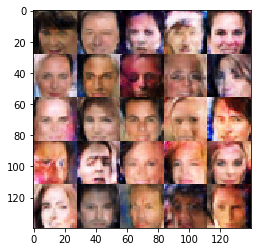

Epoch 1/1 ,  Batch 2210 ,  Generator Loss: 1.0890 ,  Discriminator Loss: 1.4011
Epoch 1/1 ,  Batch 2220 ,  Generator Loss: 0.2660 ,  Discriminator Loss: 1.9113
Epoch 1/1 ,  Batch 2230 ,  Generator Loss: 1.0202 ,  Discriminator Loss: 1.2622
Epoch 1/1 ,  Batch 2240 ,  Generator Loss: 0.3093 ,  Discriminator Loss: 1.8554
Epoch 1/1 ,  Batch 2250 ,  Generator Loss: 0.2414 ,  Discriminator Loss: 1.9378
Epoch 1/1 ,  Batch 2260 ,  Generator Loss: 1.3566 ,  Discriminator Loss: 1.3147
Epoch 1/1 ,  Batch 2270 ,  Generator Loss: 0.5125 ,  Discriminator Loss: 1.4046
Epoch 1/1 ,  Batch 2280 ,  Generator Loss: 0.3929 ,  Discriminator Loss: 1.6294
Epoch 1/1 ,  Batch 2290 ,  Generator Loss: 0.5210 ,  Discriminator Loss: 1.3808
Epoch 1/1 ,  Batch 2300 ,  Generator Loss: 0.2456 ,  Discriminator Loss: 2.0656


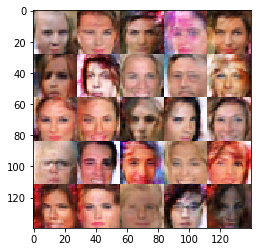

Epoch 1/1 ,  Batch 2310 ,  Generator Loss: 0.6222 ,  Discriminator Loss: 1.2115
Epoch 1/1 ,  Batch 2320 ,  Generator Loss: 0.6935 ,  Discriminator Loss: 1.4445
Epoch 1/1 ,  Batch 2330 ,  Generator Loss: 0.8971 ,  Discriminator Loss: 1.3411
Epoch 1/1 ,  Batch 2340 ,  Generator Loss: 0.8513 ,  Discriminator Loss: 1.3010
Epoch 1/1 ,  Batch 2350 ,  Generator Loss: 0.4351 ,  Discriminator Loss: 1.5042
Epoch 1/1 ,  Batch 2360 ,  Generator Loss: 1.0211 ,  Discriminator Loss: 1.2914
Epoch 1/1 ,  Batch 2370 ,  Generator Loss: 1.4374 ,  Discriminator Loss: 1.5245
Epoch 1/1 ,  Batch 2380 ,  Generator Loss: 0.4171 ,  Discriminator Loss: 1.4288
Epoch 1/1 ,  Batch 2390 ,  Generator Loss: 0.5385 ,  Discriminator Loss: 1.2833
Epoch 1/1 ,  Batch 2400 ,  Generator Loss: 0.4174 ,  Discriminator Loss: 1.4660


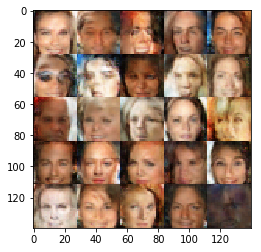

Epoch 1/1 ,  Batch 2410 ,  Generator Loss: 0.7926 ,  Discriminator Loss: 1.2078
Epoch 1/1 ,  Batch 2420 ,  Generator Loss: 0.3204 ,  Discriminator Loss: 1.8178
Epoch 1/1 ,  Batch 2430 ,  Generator Loss: 0.2437 ,  Discriminator Loss: 1.8971
Epoch 1/1 ,  Batch 2440 ,  Generator Loss: 0.5145 ,  Discriminator Loss: 1.4092
Epoch 1/1 ,  Batch 2450 ,  Generator Loss: 0.7271 ,  Discriminator Loss: 1.3492
Epoch 1/1 ,  Batch 2460 ,  Generator Loss: 0.2943 ,  Discriminator Loss: 1.8199
Epoch 1/1 ,  Batch 2470 ,  Generator Loss: 0.5599 ,  Discriminator Loss: 1.4311
Epoch 1/1 ,  Batch 2480 ,  Generator Loss: 0.8690 ,  Discriminator Loss: 1.2558
Epoch 1/1 ,  Batch 2490 ,  Generator Loss: 0.5424 ,  Discriminator Loss: 1.4337
Epoch 1/1 ,  Batch 2500 ,  Generator Loss: 0.3995 ,  Discriminator Loss: 1.5277


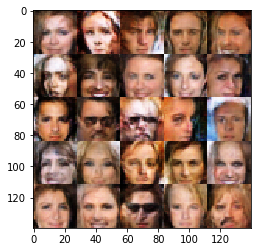

Epoch 1/1 ,  Batch 2510 ,  Generator Loss: 0.2753 ,  Discriminator Loss: 1.8552
Epoch 1/1 ,  Batch 2520 ,  Generator Loss: 0.5299 ,  Discriminator Loss: 1.3897
Epoch 1/1 ,  Batch 2530 ,  Generator Loss: 0.7488 ,  Discriminator Loss: 1.2862
Epoch 1/1 ,  Batch 2540 ,  Generator Loss: 0.5694 ,  Discriminator Loss: 1.3934
Epoch 1/1 ,  Batch 2550 ,  Generator Loss: 1.1847 ,  Discriminator Loss: 1.0701
Epoch 1/1 ,  Batch 2560 ,  Generator Loss: 0.4557 ,  Discriminator Loss: 1.5291
Epoch 1/1 ,  Batch 2570 ,  Generator Loss: 1.0059 ,  Discriminator Loss: 1.1710
Epoch 1/1 ,  Batch 2580 ,  Generator Loss: 0.4048 ,  Discriminator Loss: 1.6975
Epoch 1/1 ,  Batch 2590 ,  Generator Loss: 1.0872 ,  Discriminator Loss: 1.2315
Epoch 1/1 ,  Batch 2600 ,  Generator Loss: 0.6366 ,  Discriminator Loss: 1.1979


Epoch 1/1 ,  Batch 2610 ,  Generator Loss: 0.3411 ,  Discriminator Loss: 1.5988
Epoch 1/1 ,  Batch 2620 ,  Generator Loss: 0.5739 ,  Discriminator Loss: 1.3102
Epoch 1/1 ,  Batch 2630 ,  Generator Loss: 1.0685 ,  Discriminator Loss: 1.4451
Epoch 1/1 ,  Batch 2640 ,  Generator Loss: 0.6265 ,  Discriminator Loss: 1.2990
Epoch 1/1 ,  Batch 2650 ,  Generator Loss: 0.3798 ,  Discriminator Loss: 1.6988
Epoch 1/1 ,  Batch 2660 ,  Generator Loss: 0.6663 ,  Discriminator Loss: 1.1955
Epoch 1/1 ,  Batch 2670 ,  Generator Loss: 0.8513 ,  Discriminator Loss: 1.2755
Epoch 1/1 ,  Batch 2680 ,  Generator Loss: 0.7894 ,  Discriminator Loss: 1.1164
Epoch 1/1 ,  Batch 2690 ,  Generator Loss: 0.5854 ,  Discriminator Loss: 1.4173
Epoch 1/1 ,  Batch 2700 ,  Generator Loss: 0.7649 ,  Discriminator Loss: 1.1619


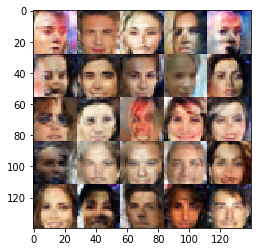

Epoch 1/1 ,  Batch 2710 ,  Generator Loss: 0.5633 ,  Discriminator Loss: 1.3914
Epoch 1/1 ,  Batch 2720 ,  Generator Loss: 1.3620 ,  Discriminator Loss: 1.2227
Epoch 1/1 ,  Batch 2730 ,  Generator Loss: 0.9229 ,  Discriminator Loss: 1.3259
Epoch 1/1 ,  Batch 2740 ,  Generator Loss: 0.5751 ,  Discriminator Loss: 1.2738
Epoch 1/1 ,  Batch 2750 ,  Generator Loss: 0.4483 ,  Discriminator Loss: 1.5615
Epoch 1/1 ,  Batch 2760 ,  Generator Loss: 0.6714 ,  Discriminator Loss: 1.2750
Epoch 1/1 ,  Batch 2770 ,  Generator Loss: 1.0810 ,  Discriminator Loss: 1.1439
Epoch 1/1 ,  Batch 2780 ,  Generator Loss: 0.8879 ,  Discriminator Loss: 1.1791
Epoch 1/1 ,  Batch 2790 ,  Generator Loss: 0.8461 ,  Discriminator Loss: 1.2130
Epoch 1/1 ,  Batch 2800 ,  Generator Loss: 0.2463 ,  Discriminator Loss: 2.0517


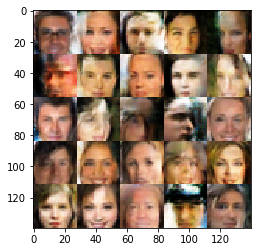

Epoch 1/1 ,  Batch 2810 ,  Generator Loss: 0.9619 ,  Discriminator Loss: 1.1780
Epoch 1/1 ,  Batch 2820 ,  Generator Loss: 0.5873 ,  Discriminator Loss: 1.3229
Epoch 1/1 ,  Batch 2830 ,  Generator Loss: 0.9685 ,  Discriminator Loss: 1.3246
Epoch 1/1 ,  Batch 2840 ,  Generator Loss: 0.4649 ,  Discriminator Loss: 1.5817
Epoch 1/1 ,  Batch 2850 ,  Generator Loss: 0.3563 ,  Discriminator Loss: 1.7201
Epoch 1/1 ,  Batch 2860 ,  Generator Loss: 0.3851 ,  Discriminator Loss: 1.7135
Epoch 1/1 ,  Batch 2870 ,  Generator Loss: 1.0941 ,  Discriminator Loss: 1.2112
Epoch 1/1 ,  Batch 2880 ,  Generator Loss: 0.6134 ,  Discriminator Loss: 1.2131
Epoch 1/1 ,  Batch 2890 ,  Generator Loss: 0.9619 ,  Discriminator Loss: 1.2456
Epoch 1/1 ,  Batch 2900 ,  Generator Loss: 0.4371 ,  Discriminator Loss: 1.3686


Epoch 1/1 ,  Batch 2910 ,  Generator Loss: 1.0262 ,  Discriminator Loss: 1.2185
Epoch 1/1 ,  Batch 2920 ,  Generator Loss: 1.0255 ,  Discriminator Loss: 1.2298
Epoch 1/1 ,  Batch 2930 ,  Generator Loss: 0.3186 ,  Discriminator Loss: 1.7447
Epoch 1/1 ,  Batch 2940 ,  Generator Loss: 0.5613 ,  Discriminator Loss: 1.3577
Epoch 1/1 ,  Batch 2950 ,  Generator Loss: 1.0829 ,  Discriminator Loss: 1.1769
Epoch 1/1 ,  Batch 2960 ,  Generator Loss: 0.5752 ,  Discriminator Loss: 1.3529
Epoch 1/1 ,  Batch 2970 ,  Generator Loss: 0.7245 ,  Discriminator Loss: 1.3074
Epoch 1/1 ,  Batch 2980 ,  Generator Loss: 0.6367 ,  Discriminator Loss: 1.2563
Epoch 1/1 ,  Batch 2990 ,  Generator Loss: 0.5568 ,  Discriminator Loss: 1.5720
Epoch 1/1 ,  Batch 3000 ,  Generator Loss: 1.0105 ,  Discriminator Loss: 1.2339


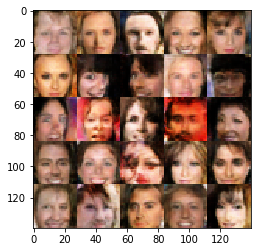

Epoch 1/1 ,  Batch 3010 ,  Generator Loss: 2.1819 ,  Discriminator Loss: 1.9357
Epoch 1/1 ,  Batch 3020 ,  Generator Loss: 0.8079 ,  Discriminator Loss: 1.2083
Epoch 1/1 ,  Batch 3030 ,  Generator Loss: 0.8321 ,  Discriminator Loss: 1.2998
Epoch 1/1 ,  Batch 3040 ,  Generator Loss: 0.4738 ,  Discriminator Loss: 1.4346
Epoch 1/1 ,  Batch 3050 ,  Generator Loss: 0.8155 ,  Discriminator Loss: 1.1567
Epoch 1/1 ,  Batch 3060 ,  Generator Loss: 0.9385 ,  Discriminator Loss: 1.3091
Epoch 1/1 ,  Batch 3070 ,  Generator Loss: 1.0473 ,  Discriminator Loss: 1.3732
Epoch 1/1 ,  Batch 3080 ,  Generator Loss: 0.6243 ,  Discriminator Loss: 1.2424
Epoch 1/1 ,  Batch 3090 ,  Generator Loss: 1.2590 ,  Discriminator Loss: 1.2006
Epoch 1/1 ,  Batch 3100 ,  Generator Loss: 0.5060 ,  Discriminator Loss: 1.3115


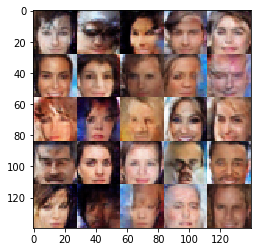

Epoch 1/1 ,  Batch 3110 ,  Generator Loss: 0.2110 ,  Discriminator Loss: 2.1753
Epoch 1/1 ,  Batch 3120 ,  Generator Loss: 1.5020 ,  Discriminator Loss: 1.2509
Epoch 1/1 ,  Batch 3130 ,  Generator Loss: 1.1669 ,  Discriminator Loss: 1.1744
Epoch 1/1 ,  Batch 3140 ,  Generator Loss: 0.8568 ,  Discriminator Loss: 1.1615
Epoch 1/1 ,  Batch 3150 ,  Generator Loss: 0.3711 ,  Discriminator Loss: 1.6965
Epoch 1/1 ,  Batch 3160 ,  Generator Loss: 0.4215 ,  Discriminator Loss: 1.5514
Epoch 1/1 ,  Batch 3170 ,  Generator Loss: 1.4644 ,  Discriminator Loss: 1.1753
Epoch 1/1 ,  Batch 3180 ,  Generator Loss: 0.7340 ,  Discriminator Loss: 1.1975
Epoch 1/1 ,  Batch 3190 ,  Generator Loss: 0.6205 ,  Discriminator Loss: 1.2885
Epoch 1/1 ,  Batch 3200 ,  Generator Loss: 0.6586 ,  Discriminator Loss: 1.1829


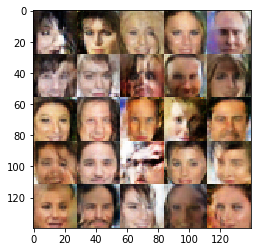

Epoch 1/1 ,  Batch 3210 ,  Generator Loss: 0.5600 ,  Discriminator Loss: 1.3059
Epoch 1/1 ,  Batch 3220 ,  Generator Loss: 1.3497 ,  Discriminator Loss: 1.2979
Epoch 1/1 ,  Batch 3230 ,  Generator Loss: 0.3959 ,  Discriminator Loss: 1.6248
Epoch 1/1 ,  Batch 3240 ,  Generator Loss: 0.6802 ,  Discriminator Loss: 1.1192
Epoch 1/1 ,  Batch 3250 ,  Generator Loss: 0.8713 ,  Discriminator Loss: 1.2371
Epoch 1/1 ,  Batch 3260 ,  Generator Loss: 1.2814 ,  Discriminator Loss: 1.3349
Epoch 1/1 ,  Batch 3270 ,  Generator Loss: 1.0432 ,  Discriminator Loss: 1.1404
Epoch 1/1 ,  Batch 3280 ,  Generator Loss: 1.7846 ,  Discriminator Loss: 1.7135
Epoch 1/1 ,  Batch 3290 ,  Generator Loss: 0.4972 ,  Discriminator Loss: 1.5178
Epoch 1/1 ,  Batch 3300 ,  Generator Loss: 1.1707 ,  Discriminator Loss: 1.2521


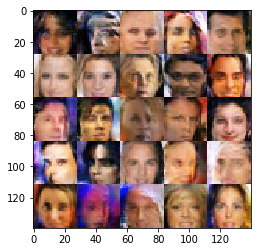

Epoch 1/1 ,  Batch 3310 ,  Generator Loss: 0.3216 ,  Discriminator Loss: 1.6879
Epoch 1/1 ,  Batch 3320 ,  Generator Loss: 0.7579 ,  Discriminator Loss: 1.2965
Epoch 1/1 ,  Batch 3330 ,  Generator Loss: 0.6507 ,  Discriminator Loss: 1.2487
Epoch 1/1 ,  Batch 3340 ,  Generator Loss: 1.2154 ,  Discriminator Loss: 1.2511
Epoch 1/1 ,  Batch 3350 ,  Generator Loss: 0.5841 ,  Discriminator Loss: 1.3294
Epoch 1/1 ,  Batch 3360 ,  Generator Loss: 1.1670 ,  Discriminator Loss: 1.2259
Epoch 1/1 ,  Batch 3370 ,  Generator Loss: 1.0512 ,  Discriminator Loss: 1.1752
Epoch 1/1 ,  Batch 3380 ,  Generator Loss: 1.4292 ,  Discriminator Loss: 1.4355
Epoch 1/1 ,  Batch 3390 ,  Generator Loss: 0.7487 ,  Discriminator Loss: 1.1846
Epoch 1/1 ,  Batch 3400 ,  Generator Loss: 0.2775 ,  Discriminator Loss: 1.8201


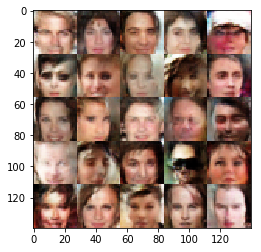

Epoch 1/1 ,  Batch 3410 ,  Generator Loss: 0.7206 ,  Discriminator Loss: 1.0899
Epoch 1/1 ,  Batch 3420 ,  Generator Loss: 0.4635 ,  Discriminator Loss: 1.4152
Epoch 1/1 ,  Batch 3430 ,  Generator Loss: 0.9568 ,  Discriminator Loss: 1.0882
Epoch 1/1 ,  Batch 3440 ,  Generator Loss: 0.9827 ,  Discriminator Loss: 1.2010
Epoch 1/1 ,  Batch 3450 ,  Generator Loss: 1.0501 ,  Discriminator Loss: 1.1455
Epoch 1/1 ,  Batch 3460 ,  Generator Loss: 1.2678 ,  Discriminator Loss: 1.0138
Epoch 1/1 ,  Batch 3470 ,  Generator Loss: 0.8749 ,  Discriminator Loss: 1.1509
Epoch 1/1 ,  Batch 3480 ,  Generator Loss: 0.5502 ,  Discriminator Loss: 1.3763
Epoch 1/1 ,  Batch 3490 ,  Generator Loss: 0.4389 ,  Discriminator Loss: 1.4124
Epoch 1/1 ,  Batch 3500 ,  Generator Loss: 0.6668 ,  Discriminator Loss: 1.5191


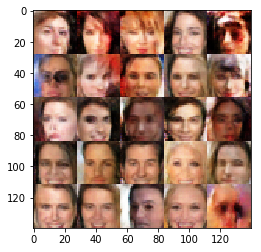

Epoch 1/1 ,  Batch 3510 ,  Generator Loss: 1.1771 ,  Discriminator Loss: 1.0228
Epoch 1/1 ,  Batch 3520 ,  Generator Loss: 0.9524 ,  Discriminator Loss: 1.1225
Epoch 1/1 ,  Batch 3530 ,  Generator Loss: 0.9790 ,  Discriminator Loss: 1.2947
Epoch 1/1 ,  Batch 3540 ,  Generator Loss: 1.1952 ,  Discriminator Loss: 1.0979
Epoch 1/1 ,  Batch 3550 ,  Generator Loss: 0.8767 ,  Discriminator Loss: 1.1240
Epoch 1/1 ,  Batch 3560 ,  Generator Loss: 1.0307 ,  Discriminator Loss: 1.0191
Epoch 1/1 ,  Batch 3570 ,  Generator Loss: 1.2946 ,  Discriminator Loss: 1.1430
Epoch 1/1 ,  Batch 3580 ,  Generator Loss: 0.8586 ,  Discriminator Loss: 1.1556
Epoch 1/1 ,  Batch 3590 ,  Generator Loss: 0.4577 ,  Discriminator Loss: 1.5315
Epoch 1/1 ,  Batch 3600 ,  Generator Loss: 0.3659 ,  Discriminator Loss: 1.5718


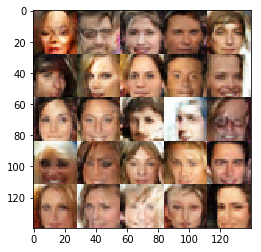

Epoch 1/1 ,  Batch 3610 ,  Generator Loss: 0.7314 ,  Discriminator Loss: 1.2022
Epoch 1/1 ,  Batch 3620 ,  Generator Loss: 1.5209 ,  Discriminator Loss: 1.4386
Epoch 1/1 ,  Batch 3630 ,  Generator Loss: 0.4470 ,  Discriminator Loss: 1.5555
Epoch 1/1 ,  Batch 3640 ,  Generator Loss: 0.8524 ,  Discriminator Loss: 1.1713
Epoch 1/1 ,  Batch 3650 ,  Generator Loss: 0.3281 ,  Discriminator Loss: 1.7595
Epoch 1/1 ,  Batch 3660 ,  Generator Loss: 0.8237 ,  Discriminator Loss: 1.1537
Epoch 1/1 ,  Batch 3670 ,  Generator Loss: 0.5820 ,  Discriminator Loss: 1.3381
Epoch 1/1 ,  Batch 3680 ,  Generator Loss: 0.7385 ,  Discriminator Loss: 1.1968
Epoch 1/1 ,  Batch 3690 ,  Generator Loss: 0.9022 ,  Discriminator Loss: 1.0544
Epoch 1/1 ,  Batch 3700 ,  Generator Loss: 0.5356 ,  Discriminator Loss: 1.4642


Epoch 1/1 ,  Batch 3710 ,  Generator Loss: 0.7427 ,  Discriminator Loss: 1.2395
Epoch 1/1 ,  Batch 3720 ,  Generator Loss: 0.4124 ,  Discriminator Loss: 1.5670
Epoch 1/1 ,  Batch 3730 ,  Generator Loss: 0.7253 ,  Discriminator Loss: 1.3217
Epoch 1/1 ,  Batch 3740 ,  Generator Loss: 0.5448 ,  Discriminator Loss: 1.3820
Epoch 1/1 ,  Batch 3750 ,  Generator Loss: 0.6052 ,  Discriminator Loss: 1.2798
Epoch 1/1 ,  Batch 3760 ,  Generator Loss: 1.3932 ,  Discriminator Loss: 1.0243
Epoch 1/1 ,  Batch 3770 ,  Generator Loss: 0.8035 ,  Discriminator Loss: 1.2656
Epoch 1/1 ,  Batch 3780 ,  Generator Loss: 0.7268 ,  Discriminator Loss: 1.1712
Epoch 1/1 ,  Batch 3790 ,  Generator Loss: 0.8872 ,  Discriminator Loss: 1.3333
Epoch 1/1 ,  Batch 3800 ,  Generator Loss: 0.8240 ,  Discriminator Loss: 1.4595


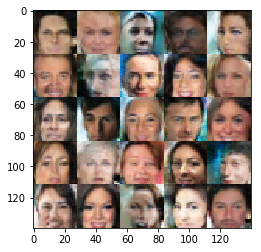

Epoch 1/1 ,  Batch 3810 ,  Generator Loss: 1.2607 ,  Discriminator Loss: 1.1299
Epoch 1/1 ,  Batch 3820 ,  Generator Loss: 0.7250 ,  Discriminator Loss: 1.2650
Epoch 1/1 ,  Batch 3830 ,  Generator Loss: 0.6354 ,  Discriminator Loss: 1.2702
Epoch 1/1 ,  Batch 3840 ,  Generator Loss: 0.6735 ,  Discriminator Loss: 1.2165
Epoch 1/1 ,  Batch 3850 ,  Generator Loss: 0.4705 ,  Discriminator Loss: 1.4388
Epoch 1/1 ,  Batch 3860 ,  Generator Loss: 1.1197 ,  Discriminator Loss: 1.0721
Epoch 1/1 ,  Batch 3870 ,  Generator Loss: 0.6560 ,  Discriminator Loss: 1.2267
Epoch 1/1 ,  Batch 3880 ,  Generator Loss: 0.4715 ,  Discriminator Loss: 1.4089
Epoch 1/1 ,  Batch 3890 ,  Generator Loss: 0.8570 ,  Discriminator Loss: 1.0658
Epoch 1/1 ,  Batch 3900 ,  Generator Loss: 0.3437 ,  Discriminator Loss: 1.5243


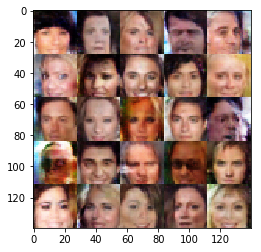

Epoch 1/1 ,  Batch 3910 ,  Generator Loss: 2.2056 ,  Discriminator Loss: 1.7231
Epoch 1/1 ,  Batch 3920 ,  Generator Loss: 0.4692 ,  Discriminator Loss: 1.5205
Epoch 1/1 ,  Batch 3930 ,  Generator Loss: 0.4437 ,  Discriminator Loss: 1.5954
Epoch 1/1 ,  Batch 3940 ,  Generator Loss: 1.6367 ,  Discriminator Loss: 1.2370
Epoch 1/1 ,  Batch 3950 ,  Generator Loss: 0.4544 ,  Discriminator Loss: 1.5160
Epoch 1/1 ,  Batch 3960 ,  Generator Loss: 0.4738 ,  Discriminator Loss: 1.3580
Epoch 1/1 ,  Batch 3970 ,  Generator Loss: 0.7480 ,  Discriminator Loss: 1.2073
Epoch 1/1 ,  Batch 3980 ,  Generator Loss: 1.1506 ,  Discriminator Loss: 1.2897
Epoch 1/1 ,  Batch 3990 ,  Generator Loss: 1.9834 ,  Discriminator Loss: 1.5012
Epoch 1/1 ,  Batch 4000 ,  Generator Loss: 0.9990 ,  Discriminator Loss: 1.0892


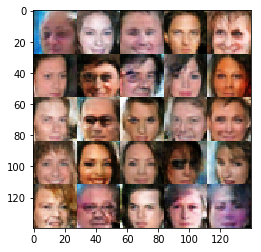

Epoch 1/1 ,  Batch 4010 ,  Generator Loss: 0.8490 ,  Discriminator Loss: 1.0731
Epoch 1/1 ,  Batch 4020 ,  Generator Loss: 0.9581 ,  Discriminator Loss: 0.9237
Epoch 1/1 ,  Batch 4030 ,  Generator Loss: 0.5516 ,  Discriminator Loss: 1.3838
Epoch 1/1 ,  Batch 4040 ,  Generator Loss: 0.3902 ,  Discriminator Loss: 1.6489
Epoch 1/1 ,  Batch 4050 ,  Generator Loss: 0.4179 ,  Discriminator Loss: 1.4683
Epoch 1/1 ,  Batch 4060 ,  Generator Loss: 1.5905 ,  Discriminator Loss: 1.4030
Epoch 1/1 ,  Batch 4070 ,  Generator Loss: 0.5118 ,  Discriminator Loss: 1.3906
Epoch 1/1 ,  Batch 4080 ,  Generator Loss: 0.4038 ,  Discriminator Loss: 1.6407
Epoch 1/1 ,  Batch 4090 ,  Generator Loss: 0.8904 ,  Discriminator Loss: 1.0174
Epoch 1/1 ,  Batch 4100 ,  Generator Loss: 0.9860 ,  Discriminator Loss: 1.0236


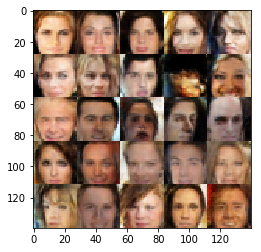

Epoch 1/1 ,  Batch 4110 ,  Generator Loss: 1.2617 ,  Discriminator Loss: 1.0833
Epoch 1/1 ,  Batch 4120 ,  Generator Loss: 0.7008 ,  Discriminator Loss: 1.1883
Epoch 1/1 ,  Batch 4130 ,  Generator Loss: 0.4124 ,  Discriminator Loss: 1.6305
Epoch 1/1 ,  Batch 4140 ,  Generator Loss: 1.1990 ,  Discriminator Loss: 1.3386
Epoch 1/1 ,  Batch 4150 ,  Generator Loss: 0.3725 ,  Discriminator Loss: 1.6982
Epoch 1/1 ,  Batch 4160 ,  Generator Loss: 0.4511 ,  Discriminator Loss: 1.4750
Epoch 1/1 ,  Batch 4170 ,  Generator Loss: 0.5233 ,  Discriminator Loss: 1.3211
Epoch 1/1 ,  Batch 4180 ,  Generator Loss: 0.5100 ,  Discriminator Loss: 1.4090
Epoch 1/1 ,  Batch 4190 ,  Generator Loss: 0.9999 ,  Discriminator Loss: 1.1698
Epoch 1/1 ,  Batch 4200 ,  Generator Loss: 0.5275 ,  Discriminator Loss: 1.3257


Epoch 1/1 ,  Batch 4210 ,  Generator Loss: 0.3741 ,  Discriminator Loss: 1.6927
Epoch 1/1 ,  Batch 4220 ,  Generator Loss: 0.3566 ,  Discriminator Loss: 1.7994
Epoch 1/1 ,  Batch 4230 ,  Generator Loss: 1.7816 ,  Discriminator Loss: 1.4121
Epoch 1/1 ,  Batch 4240 ,  Generator Loss: 1.5482 ,  Discriminator Loss: 1.5436
Epoch 1/1 ,  Batch 4250 ,  Generator Loss: 0.3384 ,  Discriminator Loss: 1.8126
Epoch 1/1 ,  Batch 4260 ,  Generator Loss: 0.8129 ,  Discriminator Loss: 1.2362
Epoch 1/1 ,  Batch 4270 ,  Generator Loss: 0.5668 ,  Discriminator Loss: 1.2506
Epoch 1/1 ,  Batch 4280 ,  Generator Loss: 0.9512 ,  Discriminator Loss: 0.9737
Epoch 1/1 ,  Batch 4290 ,  Generator Loss: 0.5813 ,  Discriminator Loss: 1.3743
Epoch 1/1 ,  Batch 4300 ,  Generator Loss: 0.7450 ,  Discriminator Loss: 1.1264


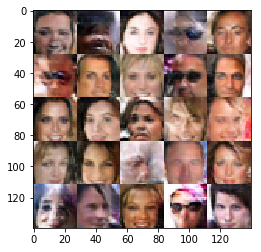

Epoch 1/1 ,  Batch 4310 ,  Generator Loss: 0.7861 ,  Discriminator Loss: 1.0046
Epoch 1/1 ,  Batch 4320 ,  Generator Loss: 0.3864 ,  Discriminator Loss: 1.5215
Epoch 1/1 ,  Batch 4330 ,  Generator Loss: 0.3630 ,  Discriminator Loss: 1.8021
Epoch 1/1 ,  Batch 4340 ,  Generator Loss: 1.3876 ,  Discriminator Loss: 1.1227
Epoch 1/1 ,  Batch 4350 ,  Generator Loss: 0.9807 ,  Discriminator Loss: 1.2371
Epoch 1/1 ,  Batch 4360 ,  Generator Loss: 0.4922 ,  Discriminator Loss: 1.3845
Epoch 1/1 ,  Batch 4370 ,  Generator Loss: 0.6915 ,  Discriminator Loss: 1.2181
Epoch 1/1 ,  Batch 4380 ,  Generator Loss: 0.8390 ,  Discriminator Loss: 0.9969
Epoch 1/1 ,  Batch 4390 ,  Generator Loss: 0.7228 ,  Discriminator Loss: 1.2679
Epoch 1/1 ,  Batch 4400 ,  Generator Loss: 0.7090 ,  Discriminator Loss: 1.1398


Epoch 1/1 ,  Batch 4410 ,  Generator Loss: 0.6484 ,  Discriminator Loss: 1.3126
Epoch 1/1 ,  Batch 4420 ,  Generator Loss: 1.1760 ,  Discriminator Loss: 0.9987
Epoch 1/1 ,  Batch 4430 ,  Generator Loss: 0.8763 ,  Discriminator Loss: 1.1358
Epoch 1/1 ,  Batch 4440 ,  Generator Loss: 0.9684 ,  Discriminator Loss: 1.0209
Epoch 1/1 ,  Batch 4450 ,  Generator Loss: 0.4729 ,  Discriminator Loss: 1.4615
Epoch 1/1 ,  Batch 4460 ,  Generator Loss: 1.0471 ,  Discriminator Loss: 0.9199
Epoch 1/1 ,  Batch 4470 ,  Generator Loss: 1.7467 ,  Discriminator Loss: 1.2905
Epoch 1/1 ,  Batch 4480 ,  Generator Loss: 0.3928 ,  Discriminator Loss: 1.5744
Epoch 1/1 ,  Batch 4490 ,  Generator Loss: 1.4768 ,  Discriminator Loss: 1.3104
Epoch 1/1 ,  Batch 4500 ,  Generator Loss: 0.4556 ,  Discriminator Loss: 1.6212


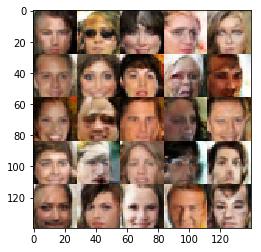

Epoch 1/1 ,  Batch 4510 ,  Generator Loss: 1.1699 ,  Discriminator Loss: 1.2847
Epoch 1/1 ,  Batch 4520 ,  Generator Loss: 0.7618 ,  Discriminator Loss: 1.1493
Epoch 1/1 ,  Batch 4530 ,  Generator Loss: 0.9509 ,  Discriminator Loss: 1.2848
Epoch 1/1 ,  Batch 4540 ,  Generator Loss: 0.6959 ,  Discriminator Loss: 1.2099
Epoch 1/1 ,  Batch 4550 ,  Generator Loss: 0.5254 ,  Discriminator Loss: 1.4739
Epoch 1/1 ,  Batch 4560 ,  Generator Loss: 0.3299 ,  Discriminator Loss: 1.8333
Epoch 1/1 ,  Batch 4570 ,  Generator Loss: 0.5148 ,  Discriminator Loss: 1.4631
Epoch 1/1 ,  Batch 4580 ,  Generator Loss: 1.2951 ,  Discriminator Loss: 0.8950
Epoch 1/1 ,  Batch 4590 ,  Generator Loss: 0.3970 ,  Discriminator Loss: 1.5657
Epoch 1/1 ,  Batch 4600 ,  Generator Loss: 0.4380 ,  Discriminator Loss: 1.5917


Epoch 1/1 ,  Batch 4610 ,  Generator Loss: 1.2186 ,  Discriminator Loss: 1.1635
Epoch 1/1 ,  Batch 4620 ,  Generator Loss: 0.5483 ,  Discriminator Loss: 1.4069
Epoch 1/1 ,  Batch 4630 ,  Generator Loss: 0.7172 ,  Discriminator Loss: 1.0470
Epoch 1/1 ,  Batch 4640 ,  Generator Loss: 1.0122 ,  Discriminator Loss: 0.8613
Epoch 1/1 ,  Batch 4650 ,  Generator Loss: 0.9602 ,  Discriminator Loss: 1.1390
Epoch 1/1 ,  Batch 4660 ,  Generator Loss: 0.7674 ,  Discriminator Loss: 1.0657
Epoch 1/1 ,  Batch 4670 ,  Generator Loss: 0.6514 ,  Discriminator Loss: 1.3004
Epoch 1/1 ,  Batch 4680 ,  Generator Loss: 0.7783 ,  Discriminator Loss: 1.1372
Epoch 1/1 ,  Batch 4690 ,  Generator Loss: 1.1286 ,  Discriminator Loss: 1.3131
Epoch 1/1 ,  Batch 4700 ,  Generator Loss: 0.7724 ,  Discriminator Loss: 1.0970


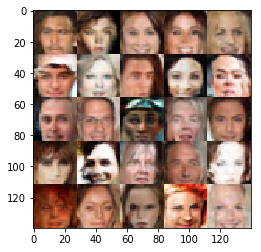

Epoch 1/1 ,  Batch 4710 ,  Generator Loss: 0.6133 ,  Discriminator Loss: 1.2746
Epoch 1/1 ,  Batch 4720 ,  Generator Loss: 1.5180 ,  Discriminator Loss: 1.0083
Epoch 1/1 ,  Batch 4730 ,  Generator Loss: 0.6744 ,  Discriminator Loss: 1.2592
Epoch 1/1 ,  Batch 4740 ,  Generator Loss: 0.7164 ,  Discriminator Loss: 1.1501
Epoch 1/1 ,  Batch 4750 ,  Generator Loss: 0.6885 ,  Discriminator Loss: 1.1657
Epoch 1/1 ,  Batch 4760 ,  Generator Loss: 1.1690 ,  Discriminator Loss: 1.0599
Epoch 1/1 ,  Batch 4770 ,  Generator Loss: 0.5662 ,  Discriminator Loss: 1.2700
Epoch 1/1 ,  Batch 4780 ,  Generator Loss: 1.0842 ,  Discriminator Loss: 0.9689
Epoch 1/1 ,  Batch 4790 ,  Generator Loss: 1.2404 ,  Discriminator Loss: 1.0440
Epoch 1/1 ,  Batch 4800 ,  Generator Loss: 0.9487 ,  Discriminator Loss: 0.8923


Epoch 1/1 ,  Batch 4810 ,  Generator Loss: 0.9831 ,  Discriminator Loss: 0.9712
Epoch 1/1 ,  Batch 4820 ,  Generator Loss: 0.5551 ,  Discriminator Loss: 1.4488
Epoch 1/1 ,  Batch 4830 ,  Generator Loss: 1.0248 ,  Discriminator Loss: 1.1008
Epoch 1/1 ,  Batch 4840 ,  Generator Loss: 1.2507 ,  Discriminator Loss: 0.9979
Epoch 1/1 ,  Batch 4850 ,  Generator Loss: 0.5433 ,  Discriminator Loss: 1.3474
Epoch 1/1 ,  Batch 4860 ,  Generator Loss: 0.7395 ,  Discriminator Loss: 1.0862
Epoch 1/1 ,  Batch 4870 ,  Generator Loss: 0.6320 ,  Discriminator Loss: 1.1799
Epoch 1/1 ,  Batch 4880 ,  Generator Loss: 0.4969 ,  Discriminator Loss: 1.5173
Epoch 1/1 ,  Batch 4890 ,  Generator Loss: 0.2599 ,  Discriminator Loss: 1.8102
Epoch 1/1 ,  Batch 4900 ,  Generator Loss: 0.8363 ,  Discriminator Loss: 1.2122


Epoch 1/1 ,  Batch 4910 ,  Generator Loss: 1.4191 ,  Discriminator Loss: 1.1437
Epoch 1/1 ,  Batch 4920 ,  Generator Loss: 0.5151 ,  Discriminator Loss: 1.2965
Epoch 1/1 ,  Batch 4930 ,  Generator Loss: 1.3441 ,  Discriminator Loss: 1.2561
Epoch 1/1 ,  Batch 4940 ,  Generator Loss: 0.5383 ,  Discriminator Loss: 1.3800
Epoch 1/1 ,  Batch 4950 ,  Generator Loss: 1.3701 ,  Discriminator Loss: 1.2770
Epoch 1/1 ,  Batch 4960 ,  Generator Loss: 1.5143 ,  Discriminator Loss: 1.0994
Epoch 1/1 ,  Batch 4970 ,  Generator Loss: 1.2344 ,  Discriminator Loss: 1.0423
Epoch 1/1 ,  Batch 4980 ,  Generator Loss: 0.6222 ,  Discriminator Loss: 1.1521
Epoch 1/1 ,  Batch 4990 ,  Generator Loss: 0.6190 ,  Discriminator Loss: 1.3121
Epoch 1/1 ,  Batch 5000 ,  Generator Loss: 1.1528 ,  Discriminator Loss: 0.9643


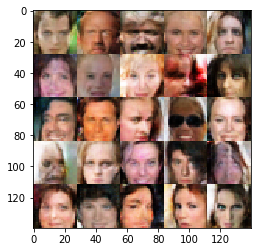

Epoch 1/1 ,  Batch 5010 ,  Generator Loss: 1.4751 ,  Discriminator Loss: 0.9719
Epoch 1/1 ,  Batch 5020 ,  Generator Loss: 1.1340 ,  Discriminator Loss: 1.0389
Epoch 1/1 ,  Batch 5030 ,  Generator Loss: 0.4277 ,  Discriminator Loss: 1.5857
Epoch 1/1 ,  Batch 5040 ,  Generator Loss: 1.3097 ,  Discriminator Loss: 1.1279
Epoch 1/1 ,  Batch 5050 ,  Generator Loss: 1.0979 ,  Discriminator Loss: 0.9979
Epoch 1/1 ,  Batch 5060 ,  Generator Loss: 0.8096 ,  Discriminator Loss: 1.0424
Epoch 1/1 ,  Batch 5070 ,  Generator Loss: 0.7126 ,  Discriminator Loss: 1.0922
Epoch 1/1 ,  Batch 5080 ,  Generator Loss: 0.7016 ,  Discriminator Loss: 1.0486
Epoch 1/1 ,  Batch 5090 ,  Generator Loss: 1.0653 ,  Discriminator Loss: 1.0256
Epoch 1/1 ,  Batch 5100 ,  Generator Loss: 1.2784 ,  Discriminator Loss: 0.9837


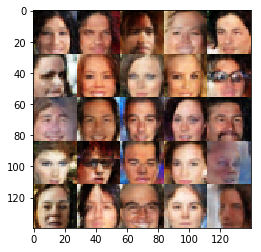

Epoch 1/1 ,  Batch 5110 ,  Generator Loss: 1.2377 ,  Discriminator Loss: 0.8340
Epoch 1/1 ,  Batch 5120 ,  Generator Loss: 1.6304 ,  Discriminator Loss: 0.9614
Epoch 1/1 ,  Batch 5130 ,  Generator Loss: 0.7419 ,  Discriminator Loss: 1.2464
Epoch 1/1 ,  Batch 5140 ,  Generator Loss: 1.1672 ,  Discriminator Loss: 1.0925
Epoch 1/1 ,  Batch 5150 ,  Generator Loss: 0.8389 ,  Discriminator Loss: 1.1271
Epoch 1/1 ,  Batch 5160 ,  Generator Loss: 1.0359 ,  Discriminator Loss: 1.0078
Epoch 1/1 ,  Batch 5170 ,  Generator Loss: 0.4070 ,  Discriminator Loss: 1.5806
Epoch 1/1 ,  Batch 5180 ,  Generator Loss: 1.2311 ,  Discriminator Loss: 0.8895
Epoch 1/1 ,  Batch 5190 ,  Generator Loss: 0.3520 ,  Discriminator Loss: 1.6971
Epoch 1/1 ,  Batch 5200 ,  Generator Loss: 1.8590 ,  Discriminator Loss: 1.1695


Epoch 1/1 ,  Batch 5210 ,  Generator Loss: 1.2735 ,  Discriminator Loss: 0.9259
Epoch 1/1 ,  Batch 5220 ,  Generator Loss: 1.2671 ,  Discriminator Loss: 1.1964
Epoch 1/1 ,  Batch 5230 ,  Generator Loss: 0.6417 ,  Discriminator Loss: 1.1901
Epoch 1/1 ,  Batch 5240 ,  Generator Loss: 0.4944 ,  Discriminator Loss: 1.4699
Epoch 1/1 ,  Batch 5250 ,  Generator Loss: 1.7103 ,  Discriminator Loss: 1.2115
Epoch 1/1 ,  Batch 5260 ,  Generator Loss: 1.4786 ,  Discriminator Loss: 1.1675
Epoch 1/1 ,  Batch 5270 ,  Generator Loss: 0.8276 ,  Discriminator Loss: 1.0589
Epoch 1/1 ,  Batch 5280 ,  Generator Loss: 1.3523 ,  Discriminator Loss: 0.8275
Epoch 1/1 ,  Batch 5290 ,  Generator Loss: 1.3495 ,  Discriminator Loss: 1.1293
Epoch 1/1 ,  Batch 5300 ,  Generator Loss: 0.2630 ,  Discriminator Loss: 1.9439


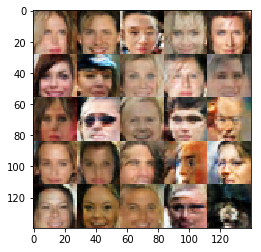

Epoch 1/1 ,  Batch 5310 ,  Generator Loss: 0.7110 ,  Discriminator Loss: 1.2292
Epoch 1/1 ,  Batch 5320 ,  Generator Loss: 1.1980 ,  Discriminator Loss: 0.9931
Epoch 1/1 ,  Batch 5330 ,  Generator Loss: 0.8668 ,  Discriminator Loss: 1.0979
Epoch 1/1 ,  Batch 5340 ,  Generator Loss: 0.3282 ,  Discriminator Loss: 1.6693
Epoch 1/1 ,  Batch 5350 ,  Generator Loss: 0.4124 ,  Discriminator Loss: 1.6103
Epoch 1/1 ,  Batch 5360 ,  Generator Loss: 0.4123 ,  Discriminator Loss: 1.5878
Epoch 1/1 ,  Batch 5370 ,  Generator Loss: 1.0866 ,  Discriminator Loss: 1.0650
Epoch 1/1 ,  Batch 5380 ,  Generator Loss: 0.9812 ,  Discriminator Loss: 0.9558
Epoch 1/1 ,  Batch 5390 ,  Generator Loss: 1.4817 ,  Discriminator Loss: 0.9098
Epoch 1/1 ,  Batch 5400 ,  Generator Loss: 1.5217 ,  Discriminator Loss: 1.1028


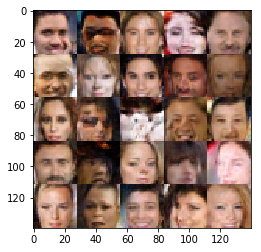

Epoch 1/1 ,  Batch 5410 ,  Generator Loss: 1.1058 ,  Discriminator Loss: 1.1586
Epoch 1/1 ,  Batch 5420 ,  Generator Loss: 1.1773 ,  Discriminator Loss: 0.9140
Epoch 1/1 ,  Batch 5430 ,  Generator Loss: 1.1586 ,  Discriminator Loss: 0.8287
Epoch 1/1 ,  Batch 5440 ,  Generator Loss: 0.7060 ,  Discriminator Loss: 1.2194
Epoch 1/1 ,  Batch 5450 ,  Generator Loss: 0.8846 ,  Discriminator Loss: 1.0141
Epoch 1/1 ,  Batch 5460 ,  Generator Loss: 0.5390 ,  Discriminator Loss: 1.3247
Epoch 1/1 ,  Batch 5470 ,  Generator Loss: 0.5217 ,  Discriminator Loss: 1.3868
Epoch 1/1 ,  Batch 5480 ,  Generator Loss: 1.7723 ,  Discriminator Loss: 1.0177
Epoch 1/1 ,  Batch 5490 ,  Generator Loss: 0.5829 ,  Discriminator Loss: 1.4267
Epoch 1/1 ,  Batch 5500 ,  Generator Loss: 0.6123 ,  Discriminator Loss: 1.1947


Epoch 1/1 ,  Batch 5510 ,  Generator Loss: 0.6973 ,  Discriminator Loss: 1.1942
Epoch 1/1 ,  Batch 5520 ,  Generator Loss: 0.7599 ,  Discriminator Loss: 1.1226
Epoch 1/1 ,  Batch 5530 ,  Generator Loss: 0.7999 ,  Discriminator Loss: 1.0854
Epoch 1/1 ,  Batch 5540 ,  Generator Loss: 1.8884 ,  Discriminator Loss: 1.1245
Epoch 1/1 ,  Batch 5550 ,  Generator Loss: 1.3793 ,  Discriminator Loss: 0.8423
Epoch 1/1 ,  Batch 5560 ,  Generator Loss: 1.2488 ,  Discriminator Loss: 1.0538
Epoch 1/1 ,  Batch 5570 ,  Generator Loss: 0.3463 ,  Discriminator Loss: 1.7883
Epoch 1/1 ,  Batch 5580 ,  Generator Loss: 0.4655 ,  Discriminator Loss: 1.5726
Epoch 1/1 ,  Batch 5590 ,  Generator Loss: 1.1315 ,  Discriminator Loss: 1.0781
Epoch 1/1 ,  Batch 5600 ,  Generator Loss: 0.6862 ,  Discriminator Loss: 1.2594


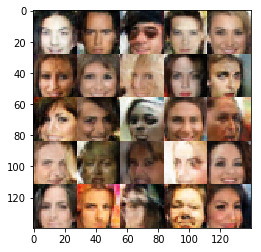

Epoch 1/1 ,  Batch 5610 ,  Generator Loss: 1.5268 ,  Discriminator Loss: 0.9368
Epoch 1/1 ,  Batch 5620 ,  Generator Loss: 1.5245 ,  Discriminator Loss: 1.0829
Epoch 1/1 ,  Batch 5630 ,  Generator Loss: 0.5843 ,  Discriminator Loss: 1.3099
Epoch 1/1 ,  Batch 5640 ,  Generator Loss: 1.2145 ,  Discriminator Loss: 0.8617
Epoch 1/1 ,  Batch 5650 ,  Generator Loss: 0.8539 ,  Discriminator Loss: 1.1361
Epoch 1/1 ,  Batch 5660 ,  Generator Loss: 0.5825 ,  Discriminator Loss: 1.3275
Epoch 1/1 ,  Batch 5670 ,  Generator Loss: 1.0759 ,  Discriminator Loss: 0.9619
Epoch 1/1 ,  Batch 5680 ,  Generator Loss: 1.4264 ,  Discriminator Loss: 1.0291
Epoch 1/1 ,  Batch 5690 ,  Generator Loss: 0.5422 ,  Discriminator Loss: 1.3719
Epoch 1/1 ,  Batch 5700 ,  Generator Loss: 0.5378 ,  Discriminator Loss: 1.5631


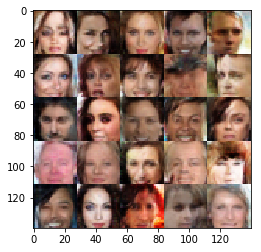

Epoch 1/1 ,  Batch 5710 ,  Generator Loss: 1.6412 ,  Discriminator Loss: 0.9474
Epoch 1/1 ,  Batch 5720 ,  Generator Loss: 0.2486 ,  Discriminator Loss: 2.2060
Epoch 1/1 ,  Batch 5730 ,  Generator Loss: 1.6932 ,  Discriminator Loss: 1.0642
Epoch 1/1 ,  Batch 5740 ,  Generator Loss: 1.2085 ,  Discriminator Loss: 0.9171
Epoch 1/1 ,  Batch 5750 ,  Generator Loss: 0.4131 ,  Discriminator Loss: 1.6052
Epoch 1/1 ,  Batch 5760 ,  Generator Loss: 0.5833 ,  Discriminator Loss: 1.3430
Epoch 1/1 ,  Batch 5770 ,  Generator Loss: 0.4956 ,  Discriminator Loss: 1.3308
Epoch 1/1 ,  Batch 5780 ,  Generator Loss: 0.5554 ,  Discriminator Loss: 1.4301
Epoch 1/1 ,  Batch 5790 ,  Generator Loss: 1.2287 ,  Discriminator Loss: 0.8557
Epoch 1/1 ,  Batch 5800 ,  Generator Loss: 1.0919 ,  Discriminator Loss: 0.8350


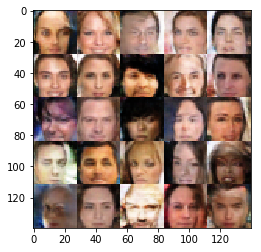

Epoch 1/1 ,  Batch 5810 ,  Generator Loss: 0.7406 ,  Discriminator Loss: 1.0902
Epoch 1/1 ,  Batch 5820 ,  Generator Loss: 0.6772 ,  Discriminator Loss: 1.2485
Epoch 1/1 ,  Batch 5830 ,  Generator Loss: 1.3156 ,  Discriminator Loss: 1.0167
Epoch 1/1 ,  Batch 5840 ,  Generator Loss: 1.3515 ,  Discriminator Loss: 0.8203
Epoch 1/1 ,  Batch 5850 ,  Generator Loss: 0.3450 ,  Discriminator Loss: 1.8130
Epoch 1/1 ,  Batch 5860 ,  Generator Loss: 1.2095 ,  Discriminator Loss: 0.9496
Epoch 1/1 ,  Batch 5870 ,  Generator Loss: 0.6117 ,  Discriminator Loss: 1.2609
Epoch 1/1 ,  Batch 5880 ,  Generator Loss: 1.5789 ,  Discriminator Loss: 1.2198
Epoch 1/1 ,  Batch 5890 ,  Generator Loss: 0.6481 ,  Discriminator Loss: 1.1970
Epoch 1/1 ,  Batch 5900 ,  Generator Loss: 1.0651 ,  Discriminator Loss: 0.9894


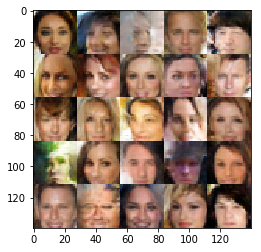

Epoch 1/1 ,  Batch 5910 ,  Generator Loss: 0.7343 ,  Discriminator Loss: 1.0611
Epoch 1/1 ,  Batch 5920 ,  Generator Loss: 0.4921 ,  Discriminator Loss: 1.3508
Epoch 1/1 ,  Batch 5930 ,  Generator Loss: 0.9651 ,  Discriminator Loss: 1.0176
Epoch 1/1 ,  Batch 5940 ,  Generator Loss: 1.0359 ,  Discriminator Loss: 0.9215
Epoch 1/1 ,  Batch 5950 ,  Generator Loss: 0.3150 ,  Discriminator Loss: 1.8505
Epoch 1/1 ,  Batch 5960 ,  Generator Loss: 1.7772 ,  Discriminator Loss: 1.0354
Epoch 1/1 ,  Batch 5970 ,  Generator Loss: 1.2876 ,  Discriminator Loss: 1.0660
Epoch 1/1 ,  Batch 5980 ,  Generator Loss: 0.5826 ,  Discriminator Loss: 1.2686
Epoch 1/1 ,  Batch 5990 ,  Generator Loss: 1.0608 ,  Discriminator Loss: 1.0839
Epoch 1/1 ,  Batch 6000 ,  Generator Loss: 0.3931 ,  Discriminator Loss: 1.8545


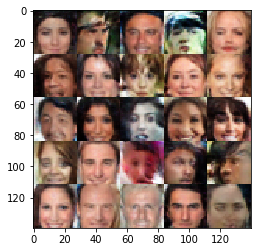

Epoch 1/1 ,  Batch 6010 ,  Generator Loss: 0.6174 ,  Discriminator Loss: 1.3050
Epoch 1/1 ,  Batch 6020 ,  Generator Loss: 0.6586 ,  Discriminator Loss: 1.1796
Epoch 1/1 ,  Batch 6030 ,  Generator Loss: 0.6313 ,  Discriminator Loss: 1.2661
Epoch 1/1 ,  Batch 6040 ,  Generator Loss: 1.2315 ,  Discriminator Loss: 0.9414
Epoch 1/1 ,  Batch 6050 ,  Generator Loss: 0.6466 ,  Discriminator Loss: 1.2804
Epoch 1/1 ,  Batch 6060 ,  Generator Loss: 0.5996 ,  Discriminator Loss: 1.3342
Epoch 1/1 ,  Batch 6070 ,  Generator Loss: 0.7601 ,  Discriminator Loss: 1.0568
Epoch 1/1 ,  Batch 6080 ,  Generator Loss: 1.0159 ,  Discriminator Loss: 0.9738
Epoch 1/1 ,  Batch 6090 ,  Generator Loss: 0.9501 ,  Discriminator Loss: 0.8929
Epoch 1/1 ,  Batch 6100 ,  Generator Loss: 1.4323 ,  Discriminator Loss: 0.9793


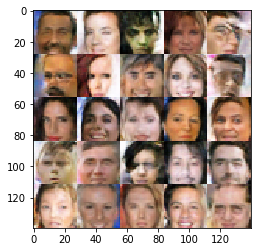

Epoch 1/1 ,  Batch 6110 ,  Generator Loss: 0.9100 ,  Discriminator Loss: 0.9699
Epoch 1/1 ,  Batch 6120 ,  Generator Loss: 0.9847 ,  Discriminator Loss: 1.0135
Epoch 1/1 ,  Batch 6130 ,  Generator Loss: 0.9164 ,  Discriminator Loss: 1.0479
Epoch 1/1 ,  Batch 6140 ,  Generator Loss: 0.7736 ,  Discriminator Loss: 1.1170
Epoch 1/1 ,  Batch 6150 ,  Generator Loss: 1.1211 ,  Discriminator Loss: 1.0245
Epoch 1/1 ,  Batch 6160 ,  Generator Loss: 0.6790 ,  Discriminator Loss: 1.1721
Epoch 1/1 ,  Batch 6170 ,  Generator Loss: 0.4810 ,  Discriminator Loss: 1.5927
Epoch 1/1 ,  Batch 6180 ,  Generator Loss: 1.1556 ,  Discriminator Loss: 1.1167
Epoch 1/1 ,  Batch 6190 ,  Generator Loss: 0.9981 ,  Discriminator Loss: 1.0378
Epoch 1/1 ,  Batch 6200 ,  Generator Loss: 1.6181 ,  Discriminator Loss: 1.0335


Epoch 1/1 ,  Batch 6210 ,  Generator Loss: 0.5846 ,  Discriminator Loss: 1.5151
Epoch 1/1 ,  Batch 6220 ,  Generator Loss: 0.9039 ,  Discriminator Loss: 1.0234
Epoch 1/1 ,  Batch 6230 ,  Generator Loss: 0.5688 ,  Discriminator Loss: 1.2904
Epoch 1/1 ,  Batch 6240 ,  Generator Loss: 2.3045 ,  Discriminator Loss: 0.8183
Epoch 1/1 ,  Batch 6250 ,  Generator Loss: 0.3233 ,  Discriminator Loss: 1.7724
Epoch 1/1 ,  Batch 6260 ,  Generator Loss: 0.6018 ,  Discriminator Loss: 1.3138
Epoch 1/1 ,  Batch 6270 ,  Generator Loss: 1.4684 ,  Discriminator Loss: 0.8139
Epoch 1/1 ,  Batch 6280 ,  Generator Loss: 1.4768 ,  Discriminator Loss: 0.9272
Epoch 1/1 ,  Batch 6290 ,  Generator Loss: 1.3995 ,  Discriminator Loss: 0.8706
Epoch 1/1 ,  Batch 6300 ,  Generator Loss: 1.6447 ,  Discriminator Loss: 1.0308


Epoch 1/1 ,  Batch 6310 ,  Generator Loss: 1.3426 ,  Discriminator Loss: 0.8151
Epoch 1/1 ,  Batch 6320 ,  Generator Loss: 0.8655 ,  Discriminator Loss: 1.2409
Epoch 1/1 ,  Batch 6330 ,  Generator Loss: 0.4360 ,  Discriminator Loss: 1.6917


In [15]:
batch_size = 32
z_dim = 256
learning_rate = 0.0005
beta1 = 0.25

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim
          , learning_rate, beta1, celeba_dataset.get_batches
          ,celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.